## dependencies

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from skimage import data
from skimage import filters
from skimage import exposure
from skimage import io
from skimage import color
from skimage import morphology
from skimage import measure
from scipy import ndimage

import gc

import time

import numpy as np
import cv2
import ntpath

from os import listdir
import os
from os.path import isfile, isdir, join

## constants & onetimers

In [2]:
EROSION_SIZE = 15
DILATION_SIZE = 15

In [3]:
sift = cv2.xfeatures2d.SIFT_create()
bruteForceMatcher = cv2.BFMatcher()

## Classes

In [4]:
class Frame:
    def __init__(self, filePath):
        
        # load bitmaps
        start = time.time()
        self.filePath = filePath
        self.fileName = ntpath.basename(filePath)
        self.imageSkimage = io.imread(filePath)
        self.grey = color.rgb2grey(self.imageSkimage)
        self.imageCV = cv2.imread(filePath)
        end = time.time()
        self.group = []
        self.similarities = []
        #print (end - start)
        
        # compute masks
        start = time.time()
        finger_mask, screen_mask = self.computeMasks()
        self.maskFinger = finger_mask
        self.maskScreen = screen_mask
        end = time.time()
        #print (end - start)
        
        self.kp = None # compute these when necessary
        self.desc = None # compute these when necessary
        
        self.assignedScene = None
        
        self.thisSceneNumber = None
        
    def dropWeight(self):
        self.imageSkimage = None
        self.grey = None
        self.imageCV = None
        self.maskFinger = None
        self.maskScreen = None
        gc.collect()
    
    def computeMasks(self):
        #locates area usable for image comparison
        
        # Otsu
        start = time.time()
        otsu_tresh = filters.threshold_otsu(self.grey)
        mask = (self.grey > otsu_tresh)
        end = time.time()
        #print (end - start)
        
        
        # Erosion & dilation
        start = time.time()        
        mask = morphology.binary_dilation(mask, morphology.square(DILATION_SIZE)).astype(int)
        mask = morphology.binary_erosion(mask, morphology.square(EROSION_SIZE))
        end = time.time()
        #print (end - start)        
        
        #For testing
        #mask = np.array([[1, 1, 1, 0],
        #                [1, 0, 0, 0],
        #                 [0, 0, 1, 0],
        #                 [0, 0, 1, 0],
        #                 [0, 0, 0, 0]])
        
        # Select largest component (screen)
        start = time.time()
        mask = measure.label(mask)
        regions = measure.regionprops(mask)
        largest_region_props = max(regions, key=lambda r: r.area)
        mask = (mask == largest_region_props.label).astype(int)
        mask = ndimage.binary_fill_holes(mask).astype(int)
        end = time.time()
        #print (end - start)

        # Get final masks (ignore fingers as much as possible)
        start = time.time() 
        finger_mask = mask
        #screen_mask = (morphology.convex_hull_image(mask)).astype(int) #takes too much time
        screen_mask = None
        end = time.time()
        #print (end - start)
        
        return finger_mask, screen_mask
    
    def computeSIFTDescriptors(self):
        start = time.time()
        gray = cv2.cvtColor(self.imageCV, cv2.COLOR_BGR2GRAY)
        self.kp, self.desc = sift.detectAndCompute(gray, mask=self.maskFinger.astype(np.uint8))
        end = time.time()
        #print ('SIFT descriptors ' + str(end - start))        
        return self.kp, self.desc
    
    def displayMasks(self):
        plt.figure(figsize=(9, 4))
        plt.subplot(131)
        plt.imshow(self.imageSkimage, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(self.maskFinger, cmap='gray', interpolation='nearest')
        plt.axis('off')
        plt.subplot(133)
        plt.imshow(self.maskScreen, cmap='gray', interpolation='nearest')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        
class EmptyFrame(Frame):
    def __init__(self):
        self.fileName = 'none'
        self.thisSceneNumber = 0
        
emptyFrame = EmptyFrame()

## routines

In [5]:
def similaritySIFT(frame, scene):
    start = time.time()
    matches = bruteForceMatcher.knnMatch(frame.desc, scene.desc, k=2)
    total = 0
    good = 0
    for m,n in matches:
        total +=1
        if m.distance < 0.75*n.distance:
            good += 1
    end = time.time()
    #print ('SIFT similarity duration ' + str(end - start))
    if total == 0: total = 1
    return good/total

In [6]:
def similaritySSIM(frame, scene):
    start = time.time()
    maskedFrame = frame.grey * frame.maskFinger
    maskedScene = scene.grey * frame.maskFinger #yes, frame's mask must be used
    res = measure.compare_ssim(maskedFrame, maskedScene, None)
    end = time.time()
    #print ('SSIM similarity duration ' + str(end - start))
    return res

# Main experiment

## Scene occurence computation scrip:

In [7]:
# SELECT EXPERIMENT SAMPLE
#sample_path = 'experiment-samples/trivial'
#sample_path = 'experiment-samples/extra-small'
#sample_path = 'experiment-samples/small-pabk'
#sample_path = 'experiment-samples-nogit/medium'
sample_path = 'experiment-samples-nogit/large-pabk'
#sample_path = 'experiment-samples-nogit/large-csob'




# LOAD AND PREPROCESS SCENES (defined by the experiment analyst)

scenes_path = sample_path + '/scenes'
scene_files = [(scenes_path+'/'+f) for f in listdir(scenes_path) if isfile(join(scenes_path, f))]
scenes = []
for path in scene_files:
    sceneFrame = Frame(path)
    sceneFrame.computeSIFTDescriptors()
    sceneFrame.thisSceneNumber = int(os.path.splitext(sceneFrame.fileName)[0])
    print('loaded scene '+str(sceneFrame.thisSceneNumber))
    scenes.append(sceneFrame)

# PROCESS EACH RECORDING
recordings_path = sample_path + '/recordings'
recordings = [d for d in listdir(recordings_path) if isdir(join(recordings_path, d))]
recordingsResults = []
for recording in recordings:
    recording_path = recordings_path + '/' + recording
    frame_files = [(recording_path+'/'+f) for f in listdir(recording_path) if isfile(join(recording_path, f))]
    frames = []
    previousFrame = None
    recordingsResults.append(frames)
    # PROCESS EACH FRAME
    for path in frame_files:
        #PREPROCESS FRAME
        frame = Frame(path) # Preprocessing takes place here
        print('loaded frame ' + frame.fileName)
        frames.append(frame)
        
        #FRAME GROUPING (not implemented in this implementation yet)
        if (previousFrame != None):
            simSSIM = similaritySSIM(frame, previousFrame)
            if (simSSIM > 0.995):
                frame.dropWeight() # drop bitmaps, memory preservation
                previousFrame.group.append(frame)
                #purposefully, we keep the previous frame at the head of the group
                continue
        
        # COMPUTE SIMILARITY AND ASSIGN SCENE
        frame.computeSIFTDescriptors()
        for scene in scenes:
            simSIFT = similaritySIFT(frame, scene)
            simSSIM = similaritySSIM(frame, scene)
            frame.similarities.append({'scene':scene, 'simSIFT':simSIFT, 'simSSIM':simSSIM})
            #print ("SIFT: " + str(simSIFT))
            #print ("SSIM: " + str(simSSIM))

                
        # Tidy up (preventing memory leaks) by removing unnecessary blobs
        if(previousFrame != None):
            previousFrame.dropWeight()

        # very last thing before we proceed to next frame
        previousFrame = frame
        #print ('     '+frame.assignedScene.fileName)
        
        

loaded scene 1
loaded scene 10
loaded scene 11
loaded scene 12
loaded scene 2
loaded scene 3
loaded scene 4
loaded scene 5
loaded scene 6
loaded scene 7
loaded scene 8
loaded scene 9
loaded frame pabk_01_00008.png
loaded frame pabk_01_00009.png
loaded frame pabk_01_00010.png
loaded frame pabk_01_00011.png
loaded frame pabk_01_00012.png
loaded frame pabk_01_00013.png
loaded frame pabk_01_00014.png
loaded frame pabk_01_00015.png
loaded frame pabk_01_00016.png
loaded frame pabk_01_00017.png
loaded frame pabk_01_00018.png
loaded frame pabk_01_00019.png
loaded frame pabk_01_00020.png
loaded frame pabk_01_00021.png
loaded frame pabk_01_00022.png
loaded frame pabk_01_00023.png
loaded frame pabk_01_00024.png
loaded frame pabk_01_00025.png
loaded frame pabk_01_00026.png
loaded frame pabk_01_00027.png
loaded frame pabk_01_00028.png
loaded frame pabk_01_00029.png
loaded frame pabk_01_00030.png
loaded frame pabk_01_00031.png
loaded frame pabk_01_00032.png
loaded frame pabk_01_00033.png
loaded fram

loaded frame pabk_01_00267.png
loaded frame pabk_01_00268.png
loaded frame pabk_01_00269.png
loaded frame pabk_01_00270.png
loaded frame pabk_01_00271.png
loaded frame pabk_01_00272.png
loaded frame pabk_01_00273.png
loaded frame pabk_01_00274.png
loaded frame pabk_01_00275.png
loaded frame pabk_01_00276.png
loaded frame pabk_01_00277.png
loaded frame pabk_01_00278.png
loaded frame pabk_01_00279.png
loaded frame pabk_01_00280.png
loaded frame pabk_01_00281.png
loaded frame pabk_01_00282.png
loaded frame pabk_01_00283.png
loaded frame pabk_01_00284.png
loaded frame pabk_01_00285.png
loaded frame pabk_01_00286.png
loaded frame pabk_01_00287.png
loaded frame pabk_01_00288.png
loaded frame pabk_01_00289.png
loaded frame pabk_01_00290.png
loaded frame pabk_01_00291.png
loaded frame pabk_01_00292.png
loaded frame pabk_01_00293.png
loaded frame pabk_01_00294.png
loaded frame pabk_01_00295.png
loaded frame pabk_01_00296.png
loaded frame pabk_01_00297.png
loaded frame pabk_01_00298.png
loaded f

loaded frame pabk_01_00532.png
loaded frame pabk_01_00533.png
loaded frame pabk_01_00534.png
loaded frame pabk_01_00535.png
loaded frame pabk_01_00536.png
loaded frame pabk_01_00537.png
loaded frame pabk_01_00538.png
loaded frame pabk_01_00539.png
loaded frame pabk_01_00540.png
loaded frame pabk_01_00541.png
loaded frame pabk_01_00542.png
loaded frame pabk_01_00543.png
loaded frame pabk_01_00544.png
loaded frame pabk_01_00545.png
loaded frame pabk_01_00546.png
loaded frame pabk_01_00547.png
loaded frame pabk_01_00548.png
loaded frame pabk_01_00549.png
loaded frame pabk_01_00550.png
loaded frame pabk_01_00551.png
loaded frame pabk_01_00552.png
loaded frame pabk_01_00553.png
loaded frame pabk_01_00554.png
loaded frame pabk_01_00555.png
loaded frame pabk_01_00556.png
loaded frame pabk_01_00557.png
loaded frame pabk_01_00558.png
loaded frame pabk_01_00559.png
loaded frame pabk_01_00560.png
loaded frame pabk_01_00561.png
loaded frame pabk_01_00562.png
loaded frame pabk_01_00563.png
loaded f

loaded frame pabk_01_00797.png
loaded frame pabk_01_00798.png
loaded frame pabk_01_00799.png
loaded frame pabk_01_00800.png
loaded frame pabk_01_00801.png
loaded frame pabk_01_00802.png
loaded frame pabk_01_00803.png
loaded frame pabk_01_00804.png
loaded frame pabk_01_00805.png
loaded frame pabk_01_00806.png
loaded frame pabk_01_00807.png
loaded frame pabk_01_00808.png
loaded frame pabk_01_00809.png
loaded frame pabk_01_00810.png
loaded frame pabk_01_00811.png
loaded frame pabk_01_00812.png
loaded frame pabk_01_00813.png
loaded frame pabk_01_00814.png
loaded frame pabk_01_00815.png
loaded frame pabk_01_00816.png
loaded frame pabk_01_00817.png
loaded frame pabk_01_00818.png
loaded frame pabk_01_00819.png
loaded frame pabk_01_00820.png
loaded frame pabk_01_00821.png
loaded frame pabk_01_00822.png
loaded frame pabk_01_00823.png
loaded frame pabk_01_00824.png
loaded frame pabk_01_00825.png
loaded frame pabk_01_00826.png
loaded frame pabk_01_00827.png
loaded frame pabk_01_00828.png
loaded f

loaded frame pabk_01_01062.png
loaded frame pabk_01_01063.png
loaded frame pabk_01_01064.png
loaded frame pabk_01_01065.png
loaded frame pabk_01_01066.png
loaded frame pabk_01_01067.png
loaded frame pabk_01_01068.png
loaded frame pabk_01_01069.png
loaded frame pabk_01_01070.png
loaded frame pabk_01_01071.png
loaded frame pabk_01_01072.png
loaded frame pabk_01_01073.png
loaded frame pabk_01_01074.png
loaded frame pabk_01_01075.png
loaded frame pabk_01_01076.png
loaded frame pabk_01_01077.png
loaded frame pabk_01_01078.png
loaded frame pabk_01_01079.png
loaded frame pabk_01_01080.png
loaded frame pabk_01_01081.png
loaded frame pabk_01_01082.png
loaded frame pabk_01_01083.png
loaded frame pabk_01_01084.png
loaded frame pabk_01_01085.png
loaded frame pabk_01_01086.png
loaded frame pabk_01_01087.png
loaded frame pabk_01_01088.png
loaded frame pabk_01_01089.png
loaded frame pabk_01_01090.png
loaded frame pabk_01_01091.png
loaded frame pabk_01_01092.png
loaded frame pabk_01_01093.png
loaded f

loaded frame pabk_01_01327.png
loaded frame pabk_01_01328.png
loaded frame pabk_01_01329.png
loaded frame pabk_01_01330.png
loaded frame pabk_01_01331.png
loaded frame pabk_01_01332.png
loaded frame pabk_01_01333.png
loaded frame pabk_01_01334.png
loaded frame pabk_01_01335.png
loaded frame pabk_01_01336.png
loaded frame pabk_01_01337.png
loaded frame pabk_01_01338.png
loaded frame pabk_01_01339.png
loaded frame pabk_01_01340.png
loaded frame pabk_01_01341.png
loaded frame pabk_01_01342.png
loaded frame pabk_01_01343.png
loaded frame pabk_01_01344.png
loaded frame pabk_01_01345.png
loaded frame pabk_01_01346.png
loaded frame pabk_01_01347.png
loaded frame pabk_01_01348.png
loaded frame pabk_01_01349.png
loaded frame pabk_01_01350.png
loaded frame pabk_01_01351.png
loaded frame pabk_01_01352.png
loaded frame pabk_01_01353.png
loaded frame pabk_01_01354.png
loaded frame pabk_01_01355.png
loaded frame pabk_01_01356.png
loaded frame pabk_01_01357.png
loaded frame pabk_01_01358.png
loaded f

loaded frame pabk_01_01592.png
loaded frame pabk_01_01593.png
loaded frame pabk_01_01594.png
loaded frame pabk_01_01595.png
loaded frame pabk_01_01596.png
loaded frame pabk_01_01597.png
loaded frame pabk_01_01598.png
loaded frame pabk_01_01599.png
loaded frame pabk_01_01600.png
loaded frame pabk_01_01601.png
loaded frame pabk_01_01602.png
loaded frame pabk_01_01603.png
loaded frame pabk_01_01604.png
loaded frame pabk_01_01605.png
loaded frame pabk_01_01606.png
loaded frame pabk_01_01607.png
loaded frame pabk_01_01608.png
loaded frame pabk_01_01609.png
loaded frame pabk_01_01610.png
loaded frame pabk_01_01611.png
loaded frame pabk_01_01612.png
loaded frame pabk_01_01613.png
loaded frame pabk_01_01614.png
loaded frame pabk_01_01615.png
loaded frame pabk_01_01616.png
loaded frame pabk_01_01617.png
loaded frame pabk_01_01618.png
loaded frame pabk_01_01619.png
loaded frame pabk_01_01620.png
loaded frame pabk_01_01621.png
loaded frame pabk_01_01622.png
loaded frame pabk_01_01623.png
loaded f

loaded frame pabk_01_01857.png
loaded frame pabk_01_01858.png
loaded frame pabk_01_01859.png
loaded frame pabk_01_01860.png
loaded frame pabk_01_01861.png
loaded frame pabk_01_01862.png
loaded frame pabk_01_01863.png
loaded frame pabk_01_01864.png
loaded frame pabk_01_01865.png
loaded frame pabk_01_01866.png
loaded frame pabk_01_01867.png
loaded frame pabk_01_01868.png
loaded frame pabk_01_01869.png
loaded frame pabk_01_01870.png
loaded frame pabk_01_01871.png
loaded frame pabk_01_01872.png
loaded frame pabk_01_01873.png
loaded frame pabk_01_01874.png
loaded frame pabk_01_01875.png
loaded frame pabk_01_01876.png
loaded frame pabk_01_01877.png
loaded frame pabk_01_01878.png
loaded frame pabk_01_01879.png
loaded frame pabk_01_01880.png
loaded frame pabk_01_01881.png
loaded frame pabk_01_01882.png
loaded frame pabk_01_01883.png
loaded frame pabk_01_01884.png
loaded frame pabk_01_01885.png
loaded frame pabk_01_01886.png
loaded frame pabk_01_01887.png
loaded frame pabk_01_01888.png
loaded f

loaded frame pabk_01_02122.png
loaded frame pabk_01_02123.png
loaded frame pabk_01_02124.png
loaded frame pabk_01_02125.png
loaded frame pabk_01_02126.png
loaded frame pabk_01_02127.png
loaded frame pabk_01_02128.png
loaded frame pabk_01_02129.png
loaded frame pabk_01_02130.png
loaded frame pabk_01_02131.png
loaded frame pabk_01_02132.png
loaded frame pabk_01_02133.png
loaded frame pabk_01_02134.png
loaded frame pabk_01_02135.png
loaded frame pabk_01_02136.png
loaded frame pabk_01_02137.png
loaded frame pabk_01_02138.png
loaded frame pabk_01_02139.png
loaded frame pabk_01_02140.png
loaded frame pabk_01_02141.png
loaded frame pabk_01_02142.png
loaded frame pabk_01_02143.png
loaded frame pabk_01_02144.png
loaded frame pabk_01_02145.png
loaded frame pabk_01_02146.png
loaded frame pabk_01_02147.png
loaded frame pabk_01_02148.png
loaded frame pabk_01_02149.png
loaded frame pabk_01_02150.png
loaded frame pabk_01_02151.png
loaded frame pabk_01_02152.png
loaded frame pabk_01_02153.png
loaded f

loaded frame pabk_01_02387.png
loaded frame pabk_01_02388.png
loaded frame pabk_01_02389.png
loaded frame pabk_01_02390.png
loaded frame pabk_01_02391.png
loaded frame pabk_01_02392.png
loaded frame pabk_01_02393.png
loaded frame pabk_01_02394.png
loaded frame pabk_01_02395.png
loaded frame pabk_01_02396.png
loaded frame pabk_01_02397.png
loaded frame pabk_01_02398.png
loaded frame pabk_01_02399.png
loaded frame pabk_01_02400.png
loaded frame pabk_01_02401.png
loaded frame pabk_01_02402.png
loaded frame pabk_01_02403.png
loaded frame pabk_01_02404.png
loaded frame pabk_01_02405.png
loaded frame pabk_01_02406.png
loaded frame pabk_01_02407.png
loaded frame pabk_01_02408.png
loaded frame pabk_01_02409.png
loaded frame pabk_01_02410.png
loaded frame pabk_01_02411.png
loaded frame pabk_01_02412.png
loaded frame pabk_01_02413.png
loaded frame pabk_01_02414.png
loaded frame pabk_01_02415.png
loaded frame pabk_01_02416.png
loaded frame pabk_01_02417.png
loaded frame pabk_01_02418.png
loaded f

loaded frame pabk_01_02652.png
loaded frame pabk_01_02653.png
loaded frame pabk_01_02654.png
loaded frame pabk_01_02655.png
loaded frame pabk_01_02656.png
loaded frame pabk_01_02657.png
loaded frame pabk_01_02658.png
loaded frame pabk_01_02659.png
loaded frame pabk_01_02660.png
loaded frame pabk_01_02661.png
loaded frame pabk_01_02662.png
loaded frame pabk_01_02663.png
loaded frame pabk_01_02664.png
loaded frame pabk_01_02665.png
loaded frame pabk_01_02666.png
loaded frame pabk_01_02667.png
loaded frame pabk_01_02668.png
loaded frame pabk_01_02669.png
loaded frame pabk_01_02670.png
loaded frame pabk_01_02671.png
loaded frame pabk_01_02672.png
loaded frame pabk_01_02673.png
loaded frame pabk_01_02674.png
loaded frame pabk_01_02675.png
loaded frame pabk_01_02676.png
loaded frame pabk_01_02677.png
loaded frame pabk_01_02678.png
loaded frame pabk_01_02679.png
loaded frame pabk_01_02680.png
loaded frame pabk_01_02681.png
loaded frame pabk_01_02682.png
loaded frame pabk_01_02683.png
loaded f

loaded frame pabk_01_02917.png
loaded frame pabk_01_02918.png
loaded frame pabk_01_02919.png
loaded frame pabk_01_02920.png
loaded frame pabk_01_02921.png
loaded frame pabk_01_02922.png
loaded frame pabk_01_02923.png
loaded frame pabk_01_02924.png
loaded frame pabk_01_02925.png
loaded frame pabk_01_02926.png
loaded frame pabk_01_02927.png
loaded frame pabk_01_02928.png
loaded frame pabk_01_02929.png
loaded frame pabk_01_02930.png
loaded frame pabk_01_02931.png
loaded frame pabk_01_02932.png
loaded frame pabk_01_02933.png
loaded frame pabk_01_02934.png
loaded frame pabk_01_02935.png
loaded frame pabk_01_02936.png
loaded frame pabk_01_02937.png
loaded frame pabk_01_02938.png
loaded frame pabk_01_02939.png
loaded frame pabk_01_02940.png
loaded frame pabk_01_02941.png
loaded frame pabk_01_02942.png
loaded frame pabk_01_02943.png
loaded frame pabk_01_02944.png
loaded frame pabk_01_02945.png
loaded frame pabk_01_02946.png
loaded frame pabk_01_02947.png
loaded frame pabk_01_02948.png
loaded f

loaded frame pabk_01_03182.png
loaded frame pabk_01_03183.png
loaded frame pabk_01_03184.png
loaded frame pabk_01_03185.png
loaded frame pabk_01_03186.png
loaded frame pabk_01_03187.png
loaded frame pabk_01_03188.png
loaded frame pabk_01_03189.png
loaded frame pabk_01_03190.png
loaded frame pabk_01_03191.png
loaded frame pabk_01_03192.png
loaded frame pabk_01_03193.png
loaded frame pabk_01_03194.png
loaded frame pabk_01_03195.png
loaded frame pabk_01_03196.png
loaded frame pabk_01_03197.png
loaded frame pabk_01_03198.png
loaded frame pabk_01_03199.png
loaded frame pabk_01_03200.png
loaded frame pabk_01_03201.png
loaded frame pabk_01_03202.png
loaded frame pabk_01_03203.png
loaded frame pabk_01_03204.png
loaded frame pabk_01_03205.png
loaded frame pabk_01_03206.png
loaded frame pabk_01_03207.png
loaded frame pabk_01_03208.png
loaded frame pabk_01_03209.png
loaded frame pabk_01_03210.png
loaded frame pabk_01_03211.png
loaded frame pabk_01_03212.png
loaded frame pabk_01_03213.png
loaded f

loaded frame pabk_01_03447.png
loaded frame pabk_01_03448.png
loaded frame pabk_01_03449.png
loaded frame pabk_01_03450.png
loaded frame pabk_01_03451.png
loaded frame pabk_01_03452.png
loaded frame pabk_01_03453.png
loaded frame pabk_01_03454.png
loaded frame pabk_01_03455.png
loaded frame pabk_01_03456.png
loaded frame pabk_01_03457.png
loaded frame pabk_01_03458.png
loaded frame pabk_01_03459.png
loaded frame pabk_01_03460.png
loaded frame pabk_01_03461.png
loaded frame pabk_01_03462.png
loaded frame pabk_01_03463.png
loaded frame pabk_01_03464.png
loaded frame pabk_01_03465.png
loaded frame pabk_01_03466.png
loaded frame pabk_01_03467.png
loaded frame pabk_01_03468.png
loaded frame pabk_01_03469.png
loaded frame pabk_01_03470.png
loaded frame pabk_01_03471.png
loaded frame pabk_01_03472.png
loaded frame pabk_01_03473.png
loaded frame pabk_01_03474.png
loaded frame pabk_01_03475.png
loaded frame pabk_01_03476.png
loaded frame pabk_01_03477.png
loaded frame pabk_01_03478.png
loaded f

loaded frame pabk_01_03712.png
loaded frame pabk_01_03713.png
loaded frame pabk_01_03714.png
loaded frame pabk_01_03715.png
loaded frame pabk_01_03716.png
loaded frame pabk_01_03717.png
loaded frame pabk_01_03718.png
loaded frame pabk_01_03719.png
loaded frame pabk_01_03720.png
loaded frame pabk_01_03721.png
loaded frame pabk_01_03722.png
loaded frame pabk_01_03723.png
loaded frame pabk_01_03724.png
loaded frame pabk_01_03725.png
loaded frame pabk_01_03726.png
loaded frame pabk_01_03727.png
loaded frame pabk_01_03728.png
loaded frame pabk_01_03729.png
loaded frame pabk_01_03730.png
loaded frame pabk_01_03731.png
loaded frame pabk_01_03732.png
loaded frame pabk_01_03733.png
loaded frame pabk_01_03734.png
loaded frame pabk_01_03735.png
loaded frame pabk_01_03736.png
loaded frame pabk_01_03737.png
loaded frame pabk_01_03738.png
loaded frame pabk_01_03739.png
loaded frame pabk_01_03740.png
loaded frame pabk_01_03741.png
loaded frame pabk_01_03742.png
loaded frame pabk_01_03743.png
loaded f

loaded frame pabk_01_03977.png
loaded frame pabk_01_03978.png
loaded frame pabk_01_03979.png
loaded frame pabk_01_03980.png
loaded frame pabk_01_03981.png
loaded frame pabk_01_03982.png
loaded frame pabk_01_03983.png
loaded frame pabk_01_03984.png
loaded frame pabk_01_03985.png
loaded frame pabk_01_03986.png
loaded frame pabk_01_03987.png
loaded frame pabk_01_03988.png
loaded frame pabk_01_03989.png
loaded frame pabk_01_03990.png
loaded frame pabk_01_03991.png
loaded frame pabk_01_03992.png
loaded frame pabk_01_03993.png
loaded frame pabk_01_03994.png
loaded frame pabk_01_03995.png
loaded frame pabk_01_03996.png
loaded frame pabk_01_03997.png
loaded frame pabk_01_03998.png
loaded frame pabk_01_03999.png
loaded frame pabk_01_04000.png
loaded frame pabk_01_04001.png
loaded frame pabk_01_04002.png
loaded frame pabk_01_04003.png
loaded frame pabk_01_04004.png
loaded frame pabk_01_04005.png
loaded frame pabk_01_04006.png
loaded frame pabk_01_04007.png
loaded frame pabk_01_04008.png
loaded f

loaded frame pabk_01_04242.png
loaded frame pabk_01_04243.png
loaded frame pabk_01_04244.png
loaded frame pabk_01_04245.png
loaded frame pabk_01_04246.png
loaded frame pabk_01_04247.png
loaded frame pabk_01_04248.png
loaded frame pabk_01_04249.png
loaded frame pabk_01_04250.png
loaded frame pabk_01_04251.png
loaded frame pabk_01_04252.png
loaded frame pabk_01_04253.png
loaded frame pabk_01_04254.png
loaded frame pabk_01_04255.png
loaded frame pabk_01_04256.png
loaded frame pabk_01_04257.png
loaded frame pabk_01_04258.png
loaded frame pabk_01_04259.png
loaded frame pabk_01_04260.png
loaded frame pabk_01_04261.png
loaded frame pabk_01_04262.png
loaded frame pabk_01_04263.png
loaded frame pabk_01_04264.png
loaded frame pabk_01_04265.png
loaded frame pabk_01_04266.png
loaded frame pabk_01_04267.png
loaded frame pabk_01_04268.png
loaded frame pabk_01_04269.png
loaded frame pabk_01_04270.png
loaded frame pabk_01_04271.png
loaded frame pabk_01_04272.png
loaded frame pabk_01_04273.png
loaded f

loaded frame pabk_01_04507.png
loaded frame pabk_01_04508.png
loaded frame pabk_01_04509.png
loaded frame pabk_01_04510.png
loaded frame pabk_01_04511.png
loaded frame pabk_01_04512.png
loaded frame pabk_01_04513.png
loaded frame pabk_01_04514.png
loaded frame pabk_01_04515.png
loaded frame pabk_01_04516.png
loaded frame pabk_01_04517.png
loaded frame pabk_01_04518.png
loaded frame pabk_01_04519.png
loaded frame pabk_01_04520.png
loaded frame pabk_01_04521.png
loaded frame pabk_01_04522.png
loaded frame pabk_01_04523.png
loaded frame pabk_01_04524.png
loaded frame pabk_01_04525.png
loaded frame pabk_01_04526.png
loaded frame pabk_01_04527.png
loaded frame pabk_01_04528.png
loaded frame pabk_01_04529.png
loaded frame pabk_01_04530.png
loaded frame pabk_01_04531.png
loaded frame pabk_01_04532.png
loaded frame pabk_01_04533.png
loaded frame pabk_01_04534.png
loaded frame pabk_01_04535.png
loaded frame pabk_01_04536.png
loaded frame pabk_01_04537.png
loaded frame pabk_01_04538.png
loaded f

loaded frame pabk_01_04772.png
loaded frame pabk_01_04773.png
loaded frame pabk_01_04774.png
loaded frame pabk_01_04775.png
loaded frame pabk_01_04776.png
loaded frame pabk_01_04777.png
loaded frame pabk_01_04778.png
loaded frame pabk_01_04779.png
loaded frame pabk_01_04780.png
loaded frame pabk_01_04781.png
loaded frame pabk_01_04782.png
loaded frame pabk_01_04783.png
loaded frame pabk_01_04784.png
loaded frame pabk_01_04785.png
loaded frame pabk_01_04786.png
loaded frame pabk_01_04787.png
loaded frame pabk_01_04788.png
loaded frame pabk_01_04789.png
loaded frame pabk_01_04790.png
loaded frame pabk_01_04791.png
loaded frame pabk_01_04792.png
loaded frame pabk_01_04793.png
loaded frame pabk_01_04794.png
loaded frame pabk_01_04795.png
loaded frame pabk_01_04796.png
loaded frame pabk_01_04797.png
loaded frame pabk_01_04798.png
loaded frame pabk_01_04799.png
loaded frame pabk_01_04800.png
loaded frame pabk_01_04801.png
loaded frame pabk_01_04802.png
loaded frame pabk_01_04803.png
loaded f

loaded frame pabk_01_05037.png
loaded frame pabk_01_05038.png
loaded frame pabk_01_05039.png
loaded frame pabk_01_05040.png
loaded frame pabk_01_05041.png
loaded frame pabk_01_05042.png
loaded frame pabk_01_05043.png
loaded frame pabk_01_05044.png
loaded frame pabk_01_05045.png
loaded frame pabk_01_05046.png
loaded frame pabk_01_05047.png
loaded frame pabk_01_05048.png
loaded frame pabk_01_05049.png
loaded frame pabk_01_05050.png
loaded frame pabk_01_05051.png
loaded frame pabk_01_05052.png
loaded frame pabk_01_05053.png
loaded frame pabk_01_05054.png
loaded frame pabk_01_05055.png
loaded frame pabk_01_05056.png
loaded frame pabk_01_05057.png
loaded frame pabk_01_05058.png
loaded frame pabk_01_05059.png
loaded frame pabk_01_05060.png
loaded frame pabk_01_05061.png
loaded frame pabk_01_05062.png
loaded frame pabk_01_05063.png
loaded frame pabk_01_05064.png
loaded frame pabk_01_05065.png
loaded frame pabk_01_05066.png
loaded frame pabk_01_05067.png
loaded frame pabk_01_05068.png
loaded f

loaded frame pabk_01_05302.png
loaded frame pabk_01_05303.png
loaded frame pabk_01_05304.png
loaded frame pabk_01_05305.png
loaded frame pabk_01_05306.png
loaded frame pabk_01_05307.png
loaded frame pabk_01_05308.png
loaded frame pabk_01_05309.png
loaded frame pabk_01_05310.png
loaded frame pabk_01_05311.png
loaded frame pabk_01_05312.png
loaded frame pabk_01_05313.png
loaded frame pabk_01_05314.png
loaded frame pabk_01_05315.png
loaded frame pabk_01_05316.png
loaded frame pabk_01_05317.png
loaded frame pabk_01_05318.png
loaded frame pabk_01_05319.png
loaded frame pabk_01_05320.png
loaded frame pabk_01_05321.png
loaded frame pabk_01_05322.png
loaded frame pabk_01_05323.png
loaded frame pabk_01_05324.png
loaded frame pabk_01_05325.png
loaded frame pabk_01_05326.png
loaded frame pabk_01_05327.png
loaded frame pabk_01_05328.png
loaded frame pabk_01_05329.png
loaded frame pabk_01_05330.png
loaded frame pabk_01_05331.png
loaded frame pabk_01_05332.png
loaded frame pabk_01_05333.png
loaded f

loaded frame pabk_01_05567.png
loaded frame pabk_01_05568.png
loaded frame pabk_01_05569.png
loaded frame pabk_01_05570.png
loaded frame pabk_01_05571.png
loaded frame pabk_01_05572.png
loaded frame pabk_01_05573.png
loaded frame pabk_01_05574.png
loaded frame pabk_01_05575.png
loaded frame pabk_01_05576.png
loaded frame pabk_01_05577.png
loaded frame pabk_01_05578.png
loaded frame pabk_01_05579.png
loaded frame pabk_01_05580.png
loaded frame pabk_01_05581.png
loaded frame pabk_01_05582.png
loaded frame pabk_01_05583.png
loaded frame pabk_01_05584.png
loaded frame pabk_01_05585.png
loaded frame pabk_01_05586.png
loaded frame pabk_01_05587.png
loaded frame pabk_01_05588.png
loaded frame pabk_01_05589.png
loaded frame pabk_01_05590.png
loaded frame pabk_01_05591.png
loaded frame pabk_01_05592.png
loaded frame pabk_01_05593.png
loaded frame pabk_01_05594.png
loaded frame pabk_01_05595.png
loaded frame pabk_01_05596.png
loaded frame pabk_01_05597.png
loaded frame pabk_01_05598.png
loaded f

loaded frame pabk_01_05832.png
loaded frame pabk_01_05833.png
loaded frame pabk_01_05834.png
loaded frame pabk_01_05835.png
loaded frame pabk_01_05836.png
loaded frame pabk_01_05837.png
loaded frame pabk_01_05838.png
loaded frame pabk_01_05839.png
loaded frame pabk_01_05840.png
loaded frame pabk_01_05841.png
loaded frame pabk_01_05842.png
loaded frame pabk_01_05843.png
loaded frame pabk_01_05844.png
loaded frame pabk_01_05845.png
loaded frame pabk_01_05846.png
loaded frame pabk_01_05847.png
loaded frame pabk_01_05848.png
loaded frame pabk_01_05849.png
loaded frame pabk_01_05850.png
loaded frame pabk_01_05851.png
loaded frame pabk_01_05852.png
loaded frame pabk_01_05853.png
loaded frame pabk_01_05854.png
loaded frame pabk_01_05855.png
loaded frame pabk_01_05856.png
loaded frame pabk_01_05857.png
loaded frame pabk_01_05858.png
loaded frame pabk_01_05859.png
loaded frame pabk_01_05860.png
loaded frame pabk_01_05861.png
loaded frame pabk_01_05862.png
loaded frame pabk_01_05863.png
loaded f

loaded frame pabk_01_06097.png
loaded frame pabk_01_06098.png
loaded frame pabk_01_06099.png
loaded frame pabk_01_06100.png
loaded frame pabk_01_06101.png
loaded frame pabk_01_06102.png
loaded frame pabk_01_06103.png
loaded frame pabk_01_06104.png
loaded frame pabk_01_06105.png
loaded frame pabk_01_06106.png
loaded frame pabk_01_06107.png
loaded frame pabk_01_06108.png
loaded frame pabk_01_06109.png
loaded frame pabk_01_06110.png
loaded frame pabk_01_06111.png
loaded frame pabk_01_06112.png
loaded frame pabk_01_06113.png
loaded frame pabk_01_06114.png
loaded frame pabk_01_06115.png
loaded frame pabk_01_06116.png
loaded frame pabk_01_06117.png
loaded frame pabk_01_06118.png
loaded frame pabk_01_06119.png
loaded frame pabk_01_06120.png
loaded frame pabk_01_06121.png
loaded frame pabk_01_06122.png
loaded frame pabk_01_06123.png
loaded frame pabk_01_06124.png
loaded frame pabk_01_06125.png
loaded frame pabk_01_06126.png
loaded frame pabk_01_06127.png
loaded frame pabk_01_06128.png
loaded f

loaded frame pabk_02_00191.png
loaded frame pabk_02_00192.png
loaded frame pabk_02_00193.png
loaded frame pabk_02_00194.png
loaded frame pabk_02_00195.png
loaded frame pabk_02_00196.png
loaded frame pabk_02_00197.png
loaded frame pabk_02_00198.png
loaded frame pabk_02_00199.png
loaded frame pabk_02_00200.png
loaded frame pabk_02_00201.png
loaded frame pabk_02_00202.png
loaded frame pabk_02_00203.png
loaded frame pabk_02_00204.png
loaded frame pabk_02_00205.png
loaded frame pabk_02_00206.png
loaded frame pabk_02_00207.png
loaded frame pabk_02_00208.png
loaded frame pabk_02_00209.png
loaded frame pabk_02_00210.png
loaded frame pabk_02_00211.png
loaded frame pabk_02_00212.png
loaded frame pabk_02_00213.png
loaded frame pabk_02_00214.png
loaded frame pabk_02_00215.png
loaded frame pabk_02_00216.png
loaded frame pabk_02_00217.png
loaded frame pabk_02_00218.png
loaded frame pabk_02_00219.png
loaded frame pabk_02_00220.png
loaded frame pabk_02_00221.png
loaded frame pabk_02_00222.png
loaded f

loaded frame pabk_02_00456.png
loaded frame pabk_02_00457.png
loaded frame pabk_02_00458.png
loaded frame pabk_02_00459.png
loaded frame pabk_02_00460.png
loaded frame pabk_02_00461.png
loaded frame pabk_02_00462.png
loaded frame pabk_02_00463.png
loaded frame pabk_02_00464.png
loaded frame pabk_02_00465.png
loaded frame pabk_02_00466.png
loaded frame pabk_02_00467.png
loaded frame pabk_02_00468.png
loaded frame pabk_02_00469.png
loaded frame pabk_02_00470.png
loaded frame pabk_02_00471.png
loaded frame pabk_02_00472.png
loaded frame pabk_02_00473.png
loaded frame pabk_02_00474.png
loaded frame pabk_02_00475.png
loaded frame pabk_02_00476.png
loaded frame pabk_02_00477.png
loaded frame pabk_02_00478.png
loaded frame pabk_02_00479.png
loaded frame pabk_02_00480.png
loaded frame pabk_02_00481.png
loaded frame pabk_02_00482.png
loaded frame pabk_02_00483.png
loaded frame pabk_02_00484.png
loaded frame pabk_02_00485.png
loaded frame pabk_02_00486.png
loaded frame pabk_02_00487.png
loaded f

loaded frame pabk_02_00721.png
loaded frame pabk_02_00722.png
loaded frame pabk_02_00723.png
loaded frame pabk_02_00724.png
loaded frame pabk_02_00725.png
loaded frame pabk_02_00726.png
loaded frame pabk_02_00727.png
loaded frame pabk_02_00728.png
loaded frame pabk_02_00729.png
loaded frame pabk_02_00730.png
loaded frame pabk_02_00731.png
loaded frame pabk_02_00732.png
loaded frame pabk_02_00733.png
loaded frame pabk_02_00734.png
loaded frame pabk_02_00735.png
loaded frame pabk_02_00736.png
loaded frame pabk_02_00737.png
loaded frame pabk_02_00738.png
loaded frame pabk_02_00739.png
loaded frame pabk_02_00740.png
loaded frame pabk_02_00741.png
loaded frame pabk_02_00742.png
loaded frame pabk_02_00743.png
loaded frame pabk_02_00744.png
loaded frame pabk_02_00745.png
loaded frame pabk_02_00746.png
loaded frame pabk_02_00747.png
loaded frame pabk_02_00748.png
loaded frame pabk_02_00749.png
loaded frame pabk_02_00750.png
loaded frame pabk_02_00751.png
loaded frame pabk_02_00752.png
loaded f

loaded frame pabk_02_00986.png
loaded frame pabk_02_00987.png
loaded frame pabk_02_00988.png
loaded frame pabk_02_00989.png
loaded frame pabk_02_00990.png
loaded frame pabk_02_00991.png
loaded frame pabk_02_00992.png
loaded frame pabk_02_00993.png
loaded frame pabk_02_00994.png
loaded frame pabk_02_00995.png
loaded frame pabk_02_00996.png
loaded frame pabk_02_00997.png
loaded frame pabk_02_00998.png
loaded frame pabk_02_00999.png
loaded frame pabk_02_01000.png
loaded frame pabk_02_01001.png
loaded frame pabk_02_01002.png
loaded frame pabk_02_01003.png
loaded frame pabk_02_01004.png
loaded frame pabk_02_01005.png
loaded frame pabk_02_01006.png
loaded frame pabk_02_01007.png
loaded frame pabk_02_01008.png
loaded frame pabk_02_01009.png
loaded frame pabk_02_01010.png
loaded frame pabk_02_01011.png
loaded frame pabk_02_01012.png
loaded frame pabk_02_01013.png
loaded frame pabk_02_01014.png
loaded frame pabk_02_01015.png
loaded frame pabk_02_01016.png
loaded frame pabk_02_01017.png
loaded f

loaded frame pabk_02_01251.png
loaded frame pabk_02_01252.png
loaded frame pabk_02_01253.png
loaded frame pabk_02_01254.png
loaded frame pabk_02_01255.png
loaded frame pabk_02_01256.png
loaded frame pabk_02_01257.png
loaded frame pabk_02_01258.png
loaded frame pabk_02_01259.png
loaded frame pabk_02_01260.png
loaded frame pabk_02_01261.png
loaded frame pabk_02_01262.png
loaded frame pabk_02_01263.png
loaded frame pabk_02_01264.png
loaded frame pabk_02_01265.png
loaded frame pabk_02_01266.png
loaded frame pabk_02_01267.png
loaded frame pabk_02_01268.png
loaded frame pabk_02_01269.png
loaded frame pabk_02_01270.png
loaded frame pabk_02_01271.png
loaded frame pabk_02_01272.png
loaded frame pabk_02_01273.png
loaded frame pabk_02_01274.png
loaded frame pabk_02_01275.png
loaded frame pabk_02_01276.png
loaded frame pabk_02_01277.png
loaded frame pabk_02_01278.png
loaded frame pabk_02_01279.png
loaded frame pabk_02_01280.png
loaded frame pabk_02_01281.png
loaded frame pabk_02_01282.png
loaded f

loaded frame pabk_02_01516.png
loaded frame pabk_02_01517.png
loaded frame pabk_02_01518.png
loaded frame pabk_02_01519.png
loaded frame pabk_02_01520.png
loaded frame pabk_02_01521.png
loaded frame pabk_02_01522.png
loaded frame pabk_02_01523.png
loaded frame pabk_02_01524.png
loaded frame pabk_02_01525.png
loaded frame pabk_02_01526.png
loaded frame pabk_02_01527.png
loaded frame pabk_02_01528.png
loaded frame pabk_02_01529.png
loaded frame pabk_02_01530.png
loaded frame pabk_02_01531.png
loaded frame pabk_02_01532.png
loaded frame pabk_02_01533.png
loaded frame pabk_02_01534.png
loaded frame pabk_02_01535.png
loaded frame pabk_02_01536.png
loaded frame pabk_02_01537.png
loaded frame pabk_02_01538.png
loaded frame pabk_02_01539.png
loaded frame pabk_02_01540.png
loaded frame pabk_02_01541.png
loaded frame pabk_02_01542.png
loaded frame pabk_02_01543.png
loaded frame pabk_02_01544.png
loaded frame pabk_02_01545.png
loaded frame pabk_02_01546.png
loaded frame pabk_02_01547.png
loaded f

loaded frame pabk_02_01781.png
loaded frame pabk_02_01782.png
loaded frame pabk_02_01783.png
loaded frame pabk_02_01784.png
loaded frame pabk_02_01785.png
loaded frame pabk_02_01786.png
loaded frame pabk_02_01787.png
loaded frame pabk_02_01788.png
loaded frame pabk_02_01789.png
loaded frame pabk_02_01790.png
loaded frame pabk_02_01791.png
loaded frame pabk_02_01792.png
loaded frame pabk_02_01793.png
loaded frame pabk_02_01794.png
loaded frame pabk_02_01795.png
loaded frame pabk_02_01796.png
loaded frame pabk_02_01797.png
loaded frame pabk_02_01798.png
loaded frame pabk_02_01799.png
loaded frame pabk_02_01800.png
loaded frame pabk_02_01801.png
loaded frame pabk_02_01802.png
loaded frame pabk_02_01803.png
loaded frame pabk_02_01804.png
loaded frame pabk_02_01805.png
loaded frame pabk_02_01806.png
loaded frame pabk_02_01807.png
loaded frame pabk_02_01808.png
loaded frame pabk_02_01809.png
loaded frame pabk_02_01810.png
loaded frame pabk_02_01811.png
loaded frame pabk_02_01812.png
loaded f

loaded frame pabk_02_02046.png
loaded frame pabk_02_02047.png
loaded frame pabk_02_02048.png
loaded frame pabk_02_02049.png
loaded frame pabk_02_02050.png
loaded frame pabk_02_02051.png
loaded frame pabk_02_02052.png
loaded frame pabk_02_02053.png
loaded frame pabk_02_02054.png
loaded frame pabk_02_02055.png
loaded frame pabk_02_02056.png
loaded frame pabk_02_02057.png
loaded frame pabk_02_02058.png
loaded frame pabk_02_02059.png
loaded frame pabk_02_02060.png
loaded frame pabk_02_02061.png
loaded frame pabk_02_02062.png
loaded frame pabk_02_02063.png
loaded frame pabk_02_02064.png
loaded frame pabk_02_02065.png
loaded frame pabk_02_02066.png
loaded frame pabk_02_02067.png
loaded frame pabk_02_02068.png
loaded frame pabk_02_02069.png
loaded frame pabk_02_02070.png
loaded frame pabk_02_02071.png
loaded frame pabk_02_02072.png
loaded frame pabk_02_02073.png
loaded frame pabk_02_02074.png
loaded frame pabk_02_02075.png
loaded frame pabk_02_02076.png
loaded frame pabk_02_02077.png
loaded f

loaded frame pabk_02_02311.png
loaded frame pabk_02_02312.png
loaded frame pabk_02_02313.png
loaded frame pabk_02_02314.png
loaded frame pabk_02_02315.png
loaded frame pabk_02_02316.png
loaded frame pabk_02_02317.png
loaded frame pabk_02_02318.png
loaded frame pabk_02_02319.png
loaded frame pabk_02_02320.png
loaded frame pabk_02_02321.png
loaded frame pabk_02_02322.png
loaded frame pabk_02_02323.png
loaded frame pabk_02_02324.png
loaded frame pabk_02_02325.png
loaded frame pabk_02_02326.png
loaded frame pabk_02_02327.png
loaded frame pabk_02_02328.png
loaded frame pabk_02_02329.png
loaded frame pabk_02_02330.png
loaded frame pabk_02_02331.png
loaded frame pabk_02_02332.png
loaded frame pabk_02_02333.png
loaded frame pabk_02_02334.png
loaded frame pabk_02_02335.png
loaded frame pabk_02_02336.png
loaded frame pabk_02_02337.png
loaded frame pabk_02_02338.png
loaded frame pabk_02_02339.png
loaded frame pabk_02_02340.png
loaded frame pabk_02_02341.png
loaded frame pabk_02_02342.png
loaded f

loaded frame pabk_02_02576.png
loaded frame pabk_02_02577.png
loaded frame pabk_02_02578.png
loaded frame pabk_02_02579.png
loaded frame pabk_02_02580.png
loaded frame pabk_02_02581.png
loaded frame pabk_02_02582.png
loaded frame pabk_02_02583.png
loaded frame pabk_02_02584.png
loaded frame pabk_02_02585.png
loaded frame pabk_02_02586.png
loaded frame pabk_02_02587.png
loaded frame pabk_02_02588.png
loaded frame pabk_02_02589.png
loaded frame pabk_02_02590.png
loaded frame pabk_02_02591.png
loaded frame pabk_02_02592.png
loaded frame pabk_02_02593.png
loaded frame pabk_02_02594.png
loaded frame pabk_02_02595.png
loaded frame pabk_02_02596.png
loaded frame pabk_02_02597.png
loaded frame pabk_02_02598.png
loaded frame pabk_02_02599.png
loaded frame pabk_02_02600.png
loaded frame pabk_02_02601.png
loaded frame pabk_02_02602.png
loaded frame pabk_02_02603.png
loaded frame pabk_02_02604.png
loaded frame pabk_02_02605.png
loaded frame pabk_02_02606.png
loaded frame pabk_02_02607.png
loaded f

loaded frame pabk_02_02841.png
loaded frame pabk_02_02842.png
loaded frame pabk_02_02843.png
loaded frame pabk_02_02844.png
loaded frame pabk_02_02845.png
loaded frame pabk_02_02846.png
loaded frame pabk_02_02847.png
loaded frame pabk_02_02848.png
loaded frame pabk_02_02849.png
loaded frame pabk_02_02850.png
loaded frame pabk_02_02851.png
loaded frame pabk_02_02852.png
loaded frame pabk_02_02853.png
loaded frame pabk_02_02854.png
loaded frame pabk_02_02855.png
loaded frame pabk_02_02856.png
loaded frame pabk_02_02857.png
loaded frame pabk_02_02858.png
loaded frame pabk_02_02859.png
loaded frame pabk_02_02860.png
loaded frame pabk_02_02861.png
loaded frame pabk_02_02862.png
loaded frame pabk_02_02863.png
loaded frame pabk_02_02864.png
loaded frame pabk_02_02865.png
loaded frame pabk_02_02866.png
loaded frame pabk_02_02867.png
loaded frame pabk_02_02868.png
loaded frame pabk_02_02869.png
loaded frame pabk_02_02870.png
loaded frame pabk_02_02871.png
loaded frame pabk_02_02872.png
loaded f

loaded frame pabk_02_03106.png
loaded frame pabk_02_03107.png
loaded frame pabk_02_03108.png
loaded frame pabk_02_03109.png
loaded frame pabk_02_03110.png
loaded frame pabk_02_03111.png
loaded frame pabk_02_03112.png
loaded frame pabk_02_03113.png
loaded frame pabk_02_03114.png
loaded frame pabk_02_03115.png
loaded frame pabk_02_03116.png
loaded frame pabk_02_03117.png
loaded frame pabk_02_03118.png
loaded frame pabk_02_03119.png
loaded frame pabk_02_03120.png
loaded frame pabk_02_03121.png
loaded frame pabk_02_03122.png
loaded frame pabk_02_03123.png
loaded frame pabk_02_03124.png
loaded frame pabk_02_03125.png
loaded frame pabk_02_03126.png
loaded frame pabk_02_03127.png
loaded frame pabk_02_03128.png
loaded frame pabk_02_03129.png
loaded frame pabk_02_03130.png
loaded frame pabk_02_03131.png
loaded frame pabk_02_03132.png
loaded frame pabk_02_03133.png
loaded frame pabk_02_03134.png
loaded frame pabk_02_03135.png
loaded frame pabk_02_03136.png
loaded frame pabk_02_03137.png
loaded f

loaded frame pabk_02_03371.png
loaded frame pabk_02_03372.png
loaded frame pabk_02_03373.png
loaded frame pabk_02_03374.png
loaded frame pabk_02_03375.png
loaded frame pabk_02_03376.png
loaded frame pabk_02_03377.png
loaded frame pabk_02_03378.png
loaded frame pabk_02_03379.png
loaded frame pabk_02_03380.png
loaded frame pabk_02_03381.png
loaded frame pabk_02_03382.png
loaded frame pabk_02_03383.png
loaded frame pabk_02_03384.png
loaded frame pabk_02_03385.png
loaded frame pabk_02_03386.png
loaded frame pabk_02_03387.png
loaded frame pabk_02_03388.png
loaded frame pabk_02_03389.png
loaded frame pabk_02_03390.png
loaded frame pabk_02_03391.png
loaded frame pabk_02_03392.png
loaded frame pabk_02_03393.png
loaded frame pabk_02_03394.png
loaded frame pabk_02_03395.png
loaded frame pabk_02_03396.png
loaded frame pabk_02_03397.png
loaded frame pabk_02_03398.png
loaded frame pabk_02_03399.png
loaded frame pabk_02_03400.png
loaded frame pabk_02_03401.png
loaded frame pabk_02_03402.png
loaded f

loaded frame pabk_02_03636.png
loaded frame pabk_02_03637.png
loaded frame pabk_02_03638.png
loaded frame pabk_02_03639.png
loaded frame pabk_02_03640.png
loaded frame pabk_02_03641.png
loaded frame pabk_02_03642.png
loaded frame pabk_02_03643.png
loaded frame pabk_02_03644.png
loaded frame pabk_02_03645.png
loaded frame pabk_02_03646.png
loaded frame pabk_02_03647.png
loaded frame pabk_02_03648.png
loaded frame pabk_02_03649.png
loaded frame pabk_02_03650.png
loaded frame pabk_02_03651.png
loaded frame pabk_02_03652.png
loaded frame pabk_02_03653.png
loaded frame pabk_02_03654.png
loaded frame pabk_02_03655.png
loaded frame pabk_02_03656.png
loaded frame pabk_02_03657.png
loaded frame pabk_02_03658.png
loaded frame pabk_02_03659.png
loaded frame pabk_02_03660.png
loaded frame pabk_02_03661.png
loaded frame pabk_02_03662.png
loaded frame pabk_02_03663.png
loaded frame pabk_02_03664.png
loaded frame pabk_02_03665.png
loaded frame pabk_02_03666.png
loaded frame pabk_02_03667.png
loaded f

loaded frame pabk_02_03901.png
loaded frame pabk_02_03902.png
loaded frame pabk_02_03903.png
loaded frame pabk_02_03904.png
loaded frame pabk_02_03905.png
loaded frame pabk_02_03906.png
loaded frame pabk_02_03907.png
loaded frame pabk_02_03908.png
loaded frame pabk_02_03909.png
loaded frame pabk_02_03910.png
loaded frame pabk_02_03911.png
loaded frame pabk_02_03912.png
loaded frame pabk_02_03913.png
loaded frame pabk_02_03914.png
loaded frame pabk_02_03915.png
loaded frame pabk_02_03916.png
loaded frame pabk_02_03917.png
loaded frame pabk_02_03918.png
loaded frame pabk_02_03919.png
loaded frame pabk_02_03920.png
loaded frame pabk_02_03921.png
loaded frame pabk_02_03922.png
loaded frame pabk_02_03923.png
loaded frame pabk_02_03924.png
loaded frame pabk_02_03925.png
loaded frame pabk_02_03926.png
loaded frame pabk_02_03927.png
loaded frame pabk_02_03928.png
loaded frame pabk_02_03929.png
loaded frame pabk_02_03930.png
loaded frame pabk_02_03931.png
loaded frame pabk_02_03932.png
loaded f

loaded frame pabk_02_04166.png
loaded frame pabk_02_04167.png
loaded frame pabk_02_04168.png
loaded frame pabk_02_04169.png
loaded frame pabk_02_04170.png
loaded frame pabk_02_04171.png
loaded frame pabk_02_04172.png
loaded frame pabk_02_04173.png
loaded frame pabk_02_04174.png
loaded frame pabk_02_04175.png
loaded frame pabk_02_04176.png
loaded frame pabk_02_04177.png
loaded frame pabk_02_04178.png
loaded frame pabk_02_04179.png
loaded frame pabk_02_04180.png
loaded frame pabk_02_04181.png
loaded frame pabk_02_04182.png
loaded frame pabk_02_04183.png
loaded frame pabk_02_04184.png
loaded frame pabk_02_04185.png
loaded frame pabk_02_04186.png
loaded frame pabk_02_04187.png
loaded frame pabk_02_04188.png
loaded frame pabk_02_04189.png
loaded frame pabk_02_04190.png
loaded frame pabk_02_04191.png
loaded frame pabk_02_04192.png
loaded frame pabk_02_04193.png
loaded frame pabk_02_04194.png
loaded frame pabk_02_04195.png
loaded frame pabk_02_04196.png
loaded frame pabk_02_04197.png
loaded f

loaded frame pabk_02_04431.png
loaded frame pabk_02_04432.png
loaded frame pabk_02_04433.png
loaded frame pabk_02_04434.png
loaded frame pabk_02_04435.png
loaded frame pabk_02_04436.png
loaded frame pabk_02_04437.png
loaded frame pabk_02_04438.png
loaded frame pabk_02_04439.png
loaded frame pabk_02_04440.png
loaded frame pabk_02_04441.png
loaded frame pabk_02_04442.png
loaded frame pabk_02_04443.png
loaded frame pabk_02_04444.png
loaded frame pabk_02_04445.png
loaded frame pabk_02_04446.png
loaded frame pabk_02_04447.png
loaded frame pabk_02_04448.png
loaded frame pabk_02_04449.png
loaded frame pabk_02_04450.png
loaded frame pabk_02_04451.png
loaded frame pabk_02_04452.png
loaded frame pabk_02_04453.png
loaded frame pabk_02_04454.png
loaded frame pabk_02_04455.png
loaded frame pabk_02_04456.png
loaded frame pabk_02_04457.png
loaded frame pabk_02_04458.png
loaded frame pabk_02_04459.png
loaded frame pabk_02_04460.png
loaded frame pabk_02_04461.png
loaded frame pabk_02_04462.png
loaded f

loaded frame pabk_02_04696.png
loaded frame pabk_02_04697.png
loaded frame pabk_02_04698.png
loaded frame pabk_02_04699.png
loaded frame pabk_02_04700.png
loaded frame pabk_02_04701.png
loaded frame pabk_02_04702.png
loaded frame pabk_02_04703.png
loaded frame pabk_02_04704.png
loaded frame pabk_02_04705.png
loaded frame pabk_02_04706.png
loaded frame pabk_02_04707.png
loaded frame pabk_02_04708.png
loaded frame pabk_02_04709.png
loaded frame pabk_02_04710.png
loaded frame pabk_02_04711.png
loaded frame pabk_02_04712.png
loaded frame pabk_02_04713.png
loaded frame pabk_02_04714.png
loaded frame pabk_02_04715.png
loaded frame pabk_02_04716.png
loaded frame pabk_02_04717.png
loaded frame pabk_02_04718.png
loaded frame pabk_02_04719.png
loaded frame pabk_02_04720.png
loaded frame pabk_02_04721.png
loaded frame pabk_02_04722.png
loaded frame pabk_02_04723.png
loaded frame pabk_02_04724.png
loaded frame pabk_02_04725.png
loaded frame pabk_02_04726.png
loaded frame pabk_02_04727.png
loaded f

loaded frame pabk_02_04961.png
loaded frame pabk_02_04962.png
loaded frame pabk_02_04963.png
loaded frame pabk_02_04964.png
loaded frame pabk_02_04965.png
loaded frame pabk_02_04966.png
loaded frame pabk_02_04967.png
loaded frame pabk_02_04968.png
loaded frame pabk_02_04969.png
loaded frame pabk_02_04970.png
loaded frame pabk_02_04971.png
loaded frame pabk_02_04972.png
loaded frame pabk_02_04973.png
loaded frame pabk_02_04974.png
loaded frame pabk_02_04975.png
loaded frame pabk_02_04976.png
loaded frame pabk_02_04977.png
loaded frame pabk_02_04978.png
loaded frame pabk_02_04979.png
loaded frame pabk_02_04980.png
loaded frame pabk_02_04981.png
loaded frame pabk_02_04982.png
loaded frame pabk_02_04983.png
loaded frame pabk_02_04984.png
loaded frame pabk_02_04985.png
loaded frame pabk_02_04986.png
loaded frame pabk_02_04987.png
loaded frame pabk_02_04988.png
loaded frame pabk_02_04989.png
loaded frame pabk_02_04990.png
loaded frame pabk_02_04991.png
loaded frame pabk_02_04992.png
loaded f

loaded frame pabk_02_05226.png
loaded frame pabk_02_05227.png
loaded frame pabk_02_05228.png
loaded frame pabk_02_05229.png
loaded frame pabk_02_05230.png
loaded frame pabk_02_05231.png
loaded frame pabk_02_05232.png
loaded frame pabk_02_05233.png
loaded frame pabk_02_05234.png
loaded frame pabk_02_05235.png
loaded frame pabk_02_05236.png
loaded frame pabk_02_05237.png
loaded frame pabk_02_05238.png
loaded frame pabk_02_05239.png
loaded frame pabk_02_05240.png
loaded frame pabk_02_05241.png
loaded frame pabk_02_05242.png
loaded frame pabk_02_05243.png
loaded frame pabk_02_05244.png
loaded frame pabk_02_05245.png
loaded frame pabk_02_05246.png
loaded frame pabk_02_05247.png
loaded frame pabk_02_05248.png
loaded frame pabk_02_05249.png
loaded frame pabk_02_05250.png
loaded frame pabk_02_05251.png
loaded frame pabk_02_05252.png
loaded frame pabk_02_05253.png
loaded frame pabk_02_05254.png
loaded frame pabk_02_05255.png
loaded frame pabk_02_05256.png
loaded frame pabk_02_05257.png
loaded f

loaded frame pabk_02_05491.png
loaded frame pabk_02_05492.png
loaded frame pabk_02_05493.png
loaded frame pabk_02_05494.png
loaded frame pabk_02_05495.png
loaded frame pabk_02_05496.png
loaded frame pabk_02_05497.png
loaded frame pabk_02_05498.png
loaded frame pabk_02_05499.png
loaded frame pabk_02_05500.png
loaded frame pabk_02_05501.png
loaded frame pabk_02_05502.png
loaded frame pabk_02_05503.png
loaded frame pabk_02_05504.png
loaded frame pabk_02_05505.png
loaded frame pabk_02_05506.png
loaded frame pabk_02_05507.png
loaded frame pabk_02_05508.png
loaded frame pabk_02_05509.png
loaded frame pabk_02_05510.png
loaded frame pabk_02_05511.png
loaded frame pabk_02_05512.png
loaded frame pabk_02_05513.png
loaded frame pabk_02_05514.png
loaded frame pabk_02_05515.png
loaded frame pabk_02_05516.png
loaded frame pabk_02_05517.png
loaded frame pabk_02_05518.png
loaded frame pabk_02_05519.png
loaded frame pabk_02_05520.png
loaded frame pabk_02_05521.png
loaded frame pabk_02_05522.png
loaded f

loaded frame pabk_03_00142.png
loaded frame pabk_03_00143.png
loaded frame pabk_03_00144.png
loaded frame pabk_03_00145.png
loaded frame pabk_03_00146.png
loaded frame pabk_03_00147.png
loaded frame pabk_03_00148.png
loaded frame pabk_03_00149.png
loaded frame pabk_03_00150.png
loaded frame pabk_03_00151.png
loaded frame pabk_03_00152.png
loaded frame pabk_03_00153.png
loaded frame pabk_03_00154.png
loaded frame pabk_03_00155.png
loaded frame pabk_03_00156.png
loaded frame pabk_03_00157.png
loaded frame pabk_03_00158.png
loaded frame pabk_03_00159.png
loaded frame pabk_03_00160.png
loaded frame pabk_03_00161.png
loaded frame pabk_03_00162.png
loaded frame pabk_03_00163.png
loaded frame pabk_03_00164.png
loaded frame pabk_03_00165.png
loaded frame pabk_03_00166.png
loaded frame pabk_03_00167.png
loaded frame pabk_03_00168.png
loaded frame pabk_03_00169.png
loaded frame pabk_03_00170.png
loaded frame pabk_03_00171.png
loaded frame pabk_03_00172.png
loaded frame pabk_03_00173.png
loaded f

loaded frame pabk_03_00407.png
loaded frame pabk_03_00408.png
loaded frame pabk_03_00409.png
loaded frame pabk_03_00410.png
loaded frame pabk_03_00411.png
loaded frame pabk_03_00412.png
loaded frame pabk_03_00413.png
loaded frame pabk_03_00414.png
loaded frame pabk_03_00415.png
loaded frame pabk_03_00416.png
loaded frame pabk_03_00417.png
loaded frame pabk_03_00418.png
loaded frame pabk_03_00419.png
loaded frame pabk_03_00420.png
loaded frame pabk_03_00421.png
loaded frame pabk_03_00422.png
loaded frame pabk_03_00423.png
loaded frame pabk_03_00424.png
loaded frame pabk_03_00425.png
loaded frame pabk_03_00426.png
loaded frame pabk_03_00427.png
loaded frame pabk_03_00428.png
loaded frame pabk_03_00429.png
loaded frame pabk_03_00430.png
loaded frame pabk_03_00431.png
loaded frame pabk_03_00432.png
loaded frame pabk_03_00433.png
loaded frame pabk_03_00434.png
loaded frame pabk_03_00435.png
loaded frame pabk_03_00436.png
loaded frame pabk_03_00437.png
loaded frame pabk_03_00438.png
loaded f

loaded frame pabk_03_00672.png
loaded frame pabk_03_00673.png
loaded frame pabk_03_00674.png
loaded frame pabk_03_00675.png
loaded frame pabk_03_00676.png
loaded frame pabk_03_00677.png
loaded frame pabk_03_00678.png
loaded frame pabk_03_00679.png
loaded frame pabk_03_00680.png
loaded frame pabk_03_00681.png
loaded frame pabk_03_00682.png
loaded frame pabk_03_00683.png
loaded frame pabk_03_00684.png
loaded frame pabk_03_00685.png
loaded frame pabk_03_00686.png
loaded frame pabk_03_00687.png
loaded frame pabk_03_00688.png
loaded frame pabk_03_00689.png
loaded frame pabk_03_00690.png
loaded frame pabk_03_00691.png
loaded frame pabk_03_00692.png
loaded frame pabk_03_00693.png
loaded frame pabk_03_00694.png
loaded frame pabk_03_00695.png
loaded frame pabk_03_00696.png
loaded frame pabk_03_00697.png
loaded frame pabk_03_00698.png
loaded frame pabk_03_00699.png
loaded frame pabk_03_00700.png
loaded frame pabk_03_00701.png
loaded frame pabk_03_00702.png
loaded frame pabk_03_00703.png
loaded f

loaded frame pabk_03_00937.png
loaded frame pabk_03_00938.png
loaded frame pabk_03_00939.png
loaded frame pabk_03_00940.png
loaded frame pabk_03_00941.png
loaded frame pabk_03_00942.png
loaded frame pabk_03_00943.png
loaded frame pabk_03_00944.png
loaded frame pabk_03_00945.png
loaded frame pabk_03_00946.png
loaded frame pabk_03_00947.png
loaded frame pabk_03_00948.png
loaded frame pabk_03_00949.png
loaded frame pabk_03_00950.png
loaded frame pabk_03_00951.png
loaded frame pabk_03_00952.png
loaded frame pabk_03_00953.png
loaded frame pabk_03_00954.png
loaded frame pabk_03_00955.png
loaded frame pabk_03_00956.png
loaded frame pabk_03_00957.png
loaded frame pabk_03_00958.png
loaded frame pabk_03_00959.png
loaded frame pabk_03_00960.png
loaded frame pabk_03_00961.png
loaded frame pabk_03_00962.png
loaded frame pabk_03_00963.png
loaded frame pabk_03_00964.png
loaded frame pabk_03_00965.png
loaded frame pabk_03_00966.png
loaded frame pabk_03_00967.png
loaded frame pabk_03_00968.png
loaded f

loaded frame pabk_03_01202.png
loaded frame pabk_03_01203.png
loaded frame pabk_03_01204.png
loaded frame pabk_03_01205.png
loaded frame pabk_03_01206.png
loaded frame pabk_03_01207.png
loaded frame pabk_03_01208.png
loaded frame pabk_03_01209.png
loaded frame pabk_03_01210.png
loaded frame pabk_03_01211.png
loaded frame pabk_03_01212.png
loaded frame pabk_03_01213.png
loaded frame pabk_03_01214.png
loaded frame pabk_03_01215.png
loaded frame pabk_03_01216.png
loaded frame pabk_03_01217.png
loaded frame pabk_03_01218.png
loaded frame pabk_03_01219.png
loaded frame pabk_03_01220.png
loaded frame pabk_03_01221.png
loaded frame pabk_03_01222.png
loaded frame pabk_03_01223.png
loaded frame pabk_03_01224.png
loaded frame pabk_03_01225.png
loaded frame pabk_03_01226.png
loaded frame pabk_03_01227.png
loaded frame pabk_03_01228.png
loaded frame pabk_03_01229.png
loaded frame pabk_03_01230.png
loaded frame pabk_03_01231.png
loaded frame pabk_03_01232.png
loaded frame pabk_03_01233.png
loaded f

loaded frame pabk_03_01467.png
loaded frame pabk_03_01468.png
loaded frame pabk_03_01469.png
loaded frame pabk_03_01470.png
loaded frame pabk_03_01471.png
loaded frame pabk_03_01472.png
loaded frame pabk_03_01473.png
loaded frame pabk_03_01474.png
loaded frame pabk_03_01475.png
loaded frame pabk_03_01476.png
loaded frame pabk_03_01477.png
loaded frame pabk_03_01478.png
loaded frame pabk_03_01479.png
loaded frame pabk_03_01480.png
loaded frame pabk_03_01481.png
loaded frame pabk_03_01482.png
loaded frame pabk_03_01483.png
loaded frame pabk_03_01484.png
loaded frame pabk_03_01485.png
loaded frame pabk_03_01486.png
loaded frame pabk_03_01487.png
loaded frame pabk_03_01488.png
loaded frame pabk_03_01489.png
loaded frame pabk_03_01490.png
loaded frame pabk_03_01491.png
loaded frame pabk_03_01492.png
loaded frame pabk_03_01493.png
loaded frame pabk_03_01494.png
loaded frame pabk_03_01495.png
loaded frame pabk_03_01496.png
loaded frame pabk_03_01497.png
loaded frame pabk_03_01498.png
loaded f

loaded frame pabk_03_01732.png
loaded frame pabk_03_01733.png
loaded frame pabk_03_01734.png
loaded frame pabk_03_01735.png
loaded frame pabk_03_01736.png
loaded frame pabk_03_01737.png
loaded frame pabk_03_01738.png
loaded frame pabk_03_01739.png
loaded frame pabk_03_01740.png
loaded frame pabk_03_01741.png
loaded frame pabk_03_01742.png
loaded frame pabk_03_01743.png
loaded frame pabk_03_01744.png
loaded frame pabk_03_01745.png
loaded frame pabk_03_01746.png
loaded frame pabk_03_01747.png
loaded frame pabk_03_01748.png
loaded frame pabk_03_01749.png
loaded frame pabk_03_01750.png
loaded frame pabk_03_01751.png
loaded frame pabk_03_01752.png
loaded frame pabk_03_01753.png
loaded frame pabk_03_01754.png
loaded frame pabk_03_01755.png
loaded frame pabk_03_01756.png
loaded frame pabk_03_01757.png
loaded frame pabk_03_01758.png
loaded frame pabk_03_01759.png
loaded frame pabk_03_01760.png
loaded frame pabk_03_01761.png
loaded frame pabk_03_01762.png
loaded frame pabk_03_01763.png
loaded f

loaded frame pabk_03_01997.png
loaded frame pabk_03_01998.png
loaded frame pabk_03_01999.png
loaded frame pabk_03_02000.png
loaded frame pabk_03_02001.png
loaded frame pabk_03_02002.png
loaded frame pabk_03_02003.png
loaded frame pabk_03_02004.png
loaded frame pabk_03_02005.png
loaded frame pabk_03_02006.png
loaded frame pabk_03_02007.png
loaded frame pabk_03_02008.png
loaded frame pabk_03_02009.png
loaded frame pabk_03_02010.png
loaded frame pabk_03_02011.png
loaded frame pabk_03_02012.png
loaded frame pabk_03_02013.png
loaded frame pabk_03_02014.png
loaded frame pabk_03_02015.png
loaded frame pabk_03_02016.png
loaded frame pabk_03_02017.png
loaded frame pabk_03_02018.png
loaded frame pabk_03_02019.png
loaded frame pabk_03_02020.png
loaded frame pabk_03_02021.png
loaded frame pabk_03_02022.png
loaded frame pabk_03_02023.png
loaded frame pabk_03_02024.png
loaded frame pabk_03_02025.png
loaded frame pabk_03_02026.png
loaded frame pabk_03_02027.png
loaded frame pabk_03_02028.png
loaded f

loaded frame pabk_03_02262.png
loaded frame pabk_03_02263.png
loaded frame pabk_03_02264.png
loaded frame pabk_03_02265.png
loaded frame pabk_03_02266.png
loaded frame pabk_03_02267.png
loaded frame pabk_03_02268.png
loaded frame pabk_03_02269.png
loaded frame pabk_03_02270.png
loaded frame pabk_03_02271.png
loaded frame pabk_03_02272.png
loaded frame pabk_03_02273.png
loaded frame pabk_03_02274.png
loaded frame pabk_03_02275.png
loaded frame pabk_03_02276.png
loaded frame pabk_03_02277.png
loaded frame pabk_03_02278.png
loaded frame pabk_03_02279.png
loaded frame pabk_03_02280.png
loaded frame pabk_03_02281.png
loaded frame pabk_03_02282.png
loaded frame pabk_03_02283.png
loaded frame pabk_03_02284.png
loaded frame pabk_03_02285.png
loaded frame pabk_03_02286.png
loaded frame pabk_03_02287.png
loaded frame pabk_03_02288.png
loaded frame pabk_03_02289.png
loaded frame pabk_03_02290.png
loaded frame pabk_03_02291.png
loaded frame pabk_03_02292.png
loaded frame pabk_03_02293.png
loaded f

loaded frame pabk_03_02527.png
loaded frame pabk_03_02528.png
loaded frame pabk_03_02529.png
loaded frame pabk_03_02530.png
loaded frame pabk_03_02531.png
loaded frame pabk_03_02532.png
loaded frame pabk_03_02533.png
loaded frame pabk_03_02534.png
loaded frame pabk_03_02535.png
loaded frame pabk_03_02536.png
loaded frame pabk_03_02537.png
loaded frame pabk_03_02538.png
loaded frame pabk_03_02539.png
loaded frame pabk_03_02540.png
loaded frame pabk_03_02541.png
loaded frame pabk_03_02542.png
loaded frame pabk_03_02543.png
loaded frame pabk_03_02544.png
loaded frame pabk_03_02545.png
loaded frame pabk_03_02546.png
loaded frame pabk_03_02547.png
loaded frame pabk_03_02548.png
loaded frame pabk_03_02549.png
loaded frame pabk_03_02550.png
loaded frame pabk_03_02551.png
loaded frame pabk_03_02552.png
loaded frame pabk_03_02553.png
loaded frame pabk_03_02554.png
loaded frame pabk_03_02555.png
loaded frame pabk_03_02556.png
loaded frame pabk_03_02557.png
loaded frame pabk_03_02558.png
loaded f

loaded frame pabk_03_02792.png
loaded frame pabk_03_02793.png
loaded frame pabk_03_02794.png
loaded frame pabk_03_02795.png
loaded frame pabk_03_02796.png
loaded frame pabk_03_02797.png
loaded frame pabk_03_02798.png
loaded frame pabk_03_02799.png
loaded frame pabk_03_02800.png
loaded frame pabk_03_02801.png
loaded frame pabk_03_02802.png
loaded frame pabk_03_02803.png
loaded frame pabk_03_02804.png
loaded frame pabk_03_02805.png
loaded frame pabk_03_02806.png
loaded frame pabk_03_02807.png
loaded frame pabk_03_02808.png
loaded frame pabk_03_02809.png
loaded frame pabk_03_02810.png
loaded frame pabk_03_02811.png
loaded frame pabk_03_02812.png
loaded frame pabk_03_02813.png
loaded frame pabk_03_02814.png
loaded frame pabk_03_02815.png
loaded frame pabk_03_02816.png
loaded frame pabk_03_02817.png
loaded frame pabk_03_02818.png
loaded frame pabk_03_02819.png
loaded frame pabk_03_02820.png
loaded frame pabk_03_02821.png
loaded frame pabk_03_02822.png
loaded frame pabk_03_02823.png
loaded f

loaded frame pabk_03_03057.png
loaded frame pabk_03_03058.png
loaded frame pabk_03_03059.png
loaded frame pabk_03_03060.png
loaded frame pabk_03_03061.png
loaded frame pabk_03_03062.png
loaded frame pabk_03_03063.png
loaded frame pabk_03_03064.png
loaded frame pabk_03_03065.png
loaded frame pabk_03_03066.png
loaded frame pabk_03_03067.png
loaded frame pabk_03_03068.png
loaded frame pabk_03_03069.png
loaded frame pabk_03_03070.png
loaded frame pabk_03_03071.png
loaded frame pabk_03_03072.png
loaded frame pabk_03_03073.png
loaded frame pabk_03_03074.png
loaded frame pabk_03_03075.png
loaded frame pabk_03_03076.png
loaded frame pabk_03_03077.png
loaded frame pabk_03_03078.png
loaded frame pabk_03_03079.png
loaded frame pabk_03_03080.png
loaded frame pabk_03_03081.png
loaded frame pabk_03_03082.png
loaded frame pabk_03_03083.png
loaded frame pabk_03_03084.png
loaded frame pabk_03_03085.png
loaded frame pabk_03_03086.png
loaded frame pabk_03_03087.png
loaded frame pabk_03_03088.png
loaded f

loaded frame pabk_03_03322.png
loaded frame pabk_03_03323.png
loaded frame pabk_03_03324.png
loaded frame pabk_03_03325.png
loaded frame pabk_03_03326.png
loaded frame pabk_03_03327.png
loaded frame pabk_03_03328.png
loaded frame pabk_03_03329.png
loaded frame pabk_03_03330.png
loaded frame pabk_03_03331.png
loaded frame pabk_03_03332.png
loaded frame pabk_03_03333.png
loaded frame pabk_03_03334.png
loaded frame pabk_03_03335.png
loaded frame pabk_03_03336.png
loaded frame pabk_03_03337.png
loaded frame pabk_03_03338.png
loaded frame pabk_03_03339.png
loaded frame pabk_03_03340.png
loaded frame pabk_03_03341.png
loaded frame pabk_03_03342.png
loaded frame pabk_03_03343.png
loaded frame pabk_03_03344.png
loaded frame pabk_03_03345.png
loaded frame pabk_03_03346.png
loaded frame pabk_03_03347.png
loaded frame pabk_03_03348.png
loaded frame pabk_03_03349.png
loaded frame pabk_03_03350.png
loaded frame pabk_03_03351.png
loaded frame pabk_03_03352.png
loaded frame pabk_03_03353.png
loaded f

loaded frame pabk_03_03587.png
loaded frame pabk_03_03588.png
loaded frame pabk_03_03589.png
loaded frame pabk_03_03590.png
loaded frame pabk_03_03591.png
loaded frame pabk_03_03592.png
loaded frame pabk_03_03593.png
loaded frame pabk_03_03594.png
loaded frame pabk_03_03595.png
loaded frame pabk_03_03596.png
loaded frame pabk_03_03597.png
loaded frame pabk_03_03598.png
loaded frame pabk_03_03599.png
loaded frame pabk_03_03600.png
loaded frame pabk_03_03601.png
loaded frame pabk_03_03602.png
loaded frame pabk_03_03603.png
loaded frame pabk_03_03604.png
loaded frame pabk_03_03605.png
loaded frame pabk_03_03606.png
loaded frame pabk_03_03607.png
loaded frame pabk_03_03608.png
loaded frame pabk_03_03609.png
loaded frame pabk_03_03610.png
loaded frame pabk_03_03611.png
loaded frame pabk_03_03612.png
loaded frame pabk_03_03613.png
loaded frame pabk_03_03614.png
loaded frame pabk_03_03615.png
loaded frame pabk_03_03616.png
loaded frame pabk_03_03617.png
loaded frame pabk_03_03618.png
loaded f

loaded frame pabk_03_03852.png
loaded frame pabk_03_03853.png
loaded frame pabk_03_03854.png
loaded frame pabk_03_03855.png
loaded frame pabk_03_03856.png
loaded frame pabk_03_03857.png
loaded frame pabk_03_03858.png
loaded frame pabk_03_03859.png
loaded frame pabk_03_03860.png
loaded frame pabk_03_03861.png
loaded frame pabk_03_03862.png
loaded frame pabk_03_03863.png
loaded frame pabk_03_03864.png
loaded frame pabk_03_03865.png
loaded frame pabk_03_03866.png
loaded frame pabk_03_03867.png
loaded frame pabk_03_03868.png
loaded frame pabk_03_03869.png
loaded frame pabk_03_03870.png
loaded frame pabk_03_03871.png
loaded frame pabk_03_03872.png
loaded frame pabk_03_03873.png
loaded frame pabk_03_03874.png
loaded frame pabk_03_03875.png
loaded frame pabk_03_03876.png
loaded frame pabk_03_03877.png
loaded frame pabk_03_03878.png
loaded frame pabk_03_03879.png
loaded frame pabk_03_03880.png
loaded frame pabk_03_03881.png
loaded frame pabk_03_03882.png
loaded frame pabk_03_03883.png
loaded f

loaded frame pabk_03_04117.png
loaded frame pabk_03_04118.png
loaded frame pabk_03_04119.png
loaded frame pabk_03_04120.png
loaded frame pabk_03_04121.png
loaded frame pabk_03_04122.png
loaded frame pabk_03_04123.png
loaded frame pabk_03_04124.png
loaded frame pabk_03_04125.png
loaded frame pabk_03_04126.png
loaded frame pabk_03_04127.png
loaded frame pabk_03_04128.png
loaded frame pabk_03_04129.png
loaded frame pabk_03_04130.png
loaded frame pabk_03_04131.png
loaded frame pabk_03_04132.png
loaded frame pabk_03_04133.png
loaded frame pabk_03_04134.png
loaded frame pabk_03_04135.png
loaded frame pabk_03_04136.png
loaded frame pabk_03_04137.png
loaded frame pabk_03_04138.png
loaded frame pabk_03_04139.png
loaded frame pabk_03_04140.png
loaded frame pabk_03_04141.png
loaded frame pabk_03_04142.png
loaded frame pabk_03_04143.png
loaded frame pabk_03_04144.png
loaded frame pabk_03_04145.png
loaded frame pabk_03_04146.png
loaded frame pabk_03_04147.png
loaded frame pabk_03_04148.png
loaded f

loaded frame pabk_03_04382.png
loaded frame pabk_03_04383.png
loaded frame pabk_03_04384.png
loaded frame pabk_03_04385.png
loaded frame pabk_03_04386.png
loaded frame pabk_03_04387.png
loaded frame pabk_03_04388.png
loaded frame pabk_03_04389.png
loaded frame pabk_03_04390.png
loaded frame pabk_03_04391.png
loaded frame pabk_03_04392.png
loaded frame pabk_03_04393.png
loaded frame pabk_03_04394.png
loaded frame pabk_03_04395.png
loaded frame pabk_03_04396.png
loaded frame pabk_03_04397.png
loaded frame pabk_03_04398.png
loaded frame pabk_03_04399.png
loaded frame pabk_03_04400.png
loaded frame pabk_03_04401.png
loaded frame pabk_03_04402.png
loaded frame pabk_03_04403.png
loaded frame pabk_03_04404.png
loaded frame pabk_03_04405.png
loaded frame pabk_03_04406.png
loaded frame pabk_03_04407.png
loaded frame pabk_03_04408.png
loaded frame pabk_03_04409.png
loaded frame pabk_03_04410.png
loaded frame pabk_03_04411.png
loaded frame pabk_03_04412.png
loaded frame pabk_03_04413.png
loaded f

loaded frame pabk_03_04647.png
loaded frame pabk_03_04648.png
loaded frame pabk_03_04649.png
loaded frame pabk_03_04650.png
loaded frame pabk_03_04651.png
loaded frame pabk_03_04652.png
loaded frame pabk_03_04653.png
loaded frame pabk_03_04654.png
loaded frame pabk_03_04655.png
loaded frame pabk_03_04656.png
loaded frame pabk_03_04657.png
loaded frame pabk_03_04658.png
loaded frame pabk_03_04659.png
loaded frame pabk_03_04660.png
loaded frame pabk_03_04661.png
loaded frame pabk_03_04662.png
loaded frame pabk_03_04663.png
loaded frame pabk_03_04664.png
loaded frame pabk_03_04665.png
loaded frame pabk_03_04666.png
loaded frame pabk_03_04667.png
loaded frame pabk_03_04668.png
loaded frame pabk_03_04669.png
loaded frame pabk_03_04670.png
loaded frame pabk_03_04671.png
loaded frame pabk_03_04672.png
loaded frame pabk_03_04673.png
loaded frame pabk_03_04674.png
loaded frame pabk_03_04675.png
loaded frame pabk_03_04676.png
loaded frame pabk_03_04677.png
loaded frame pabk_03_04678.png
loaded f

loaded frame pabk_03_04912.png
loaded frame pabk_03_04913.png
loaded frame pabk_03_04914.png
loaded frame pabk_03_04915.png
loaded frame pabk_03_04916.png
loaded frame pabk_03_04917.png
loaded frame pabk_03_04918.png
loaded frame pabk_03_04919.png
loaded frame pabk_03_04920.png
loaded frame pabk_03_04921.png
loaded frame pabk_03_04922.png
loaded frame pabk_03_04923.png
loaded frame pabk_03_04924.png
loaded frame pabk_03_04925.png
loaded frame pabk_03_04926.png
loaded frame pabk_03_04927.png
loaded frame pabk_03_04928.png
loaded frame pabk_03_04929.png
loaded frame pabk_03_04930.png
loaded frame pabk_03_04931.png
loaded frame pabk_03_04932.png
loaded frame pabk_03_04933.png
loaded frame pabk_03_04934.png
loaded frame pabk_03_04935.png
loaded frame pabk_03_04936.png
loaded frame pabk_03_04937.png
loaded frame pabk_03_04938.png
loaded frame pabk_03_04939.png
loaded frame pabk_03_04940.png
loaded frame pabk_03_04941.png
loaded frame pabk_03_04942.png
loaded frame pabk_03_04943.png
loaded f

loaded frame pabk_04_00189.png
loaded frame pabk_04_00190.png
loaded frame pabk_04_00191.png
loaded frame pabk_04_00192.png
loaded frame pabk_04_00193.png
loaded frame pabk_04_00194.png
loaded frame pabk_04_00195.png
loaded frame pabk_04_00196.png
loaded frame pabk_04_00197.png
loaded frame pabk_04_00198.png
loaded frame pabk_04_00199.png
loaded frame pabk_04_00200.png
loaded frame pabk_04_00201.png
loaded frame pabk_04_00202.png
loaded frame pabk_04_00203.png
loaded frame pabk_04_00204.png
loaded frame pabk_04_00205.png
loaded frame pabk_04_00206.png
loaded frame pabk_04_00207.png
loaded frame pabk_04_00208.png
loaded frame pabk_04_00209.png
loaded frame pabk_04_00210.png
loaded frame pabk_04_00211.png
loaded frame pabk_04_00212.png
loaded frame pabk_04_00213.png
loaded frame pabk_04_00214.png
loaded frame pabk_04_00215.png
loaded frame pabk_04_00216.png
loaded frame pabk_04_00217.png
loaded frame pabk_04_00218.png
loaded frame pabk_04_00219.png
loaded frame pabk_04_00220.png
loaded f

loaded frame pabk_04_00454.png
loaded frame pabk_04_00455.png
loaded frame pabk_04_00456.png
loaded frame pabk_04_00457.png
loaded frame pabk_04_00458.png
loaded frame pabk_04_00459.png
loaded frame pabk_04_00460.png
loaded frame pabk_04_00461.png
loaded frame pabk_04_00462.png
loaded frame pabk_04_00463.png
loaded frame pabk_04_00464.png
loaded frame pabk_04_00465.png
loaded frame pabk_04_00466.png
loaded frame pabk_04_00467.png
loaded frame pabk_04_00468.png
loaded frame pabk_04_00469.png
loaded frame pabk_04_00470.png
loaded frame pabk_04_00471.png
loaded frame pabk_04_00472.png
loaded frame pabk_04_00473.png
loaded frame pabk_04_00474.png
loaded frame pabk_04_00475.png
loaded frame pabk_04_00476.png
loaded frame pabk_04_00477.png
loaded frame pabk_04_00478.png
loaded frame pabk_04_00479.png
loaded frame pabk_04_00480.png
loaded frame pabk_04_00481.png
loaded frame pabk_04_00482.png
loaded frame pabk_04_00483.png
loaded frame pabk_04_00484.png
loaded frame pabk_04_00485.png
loaded f

loaded frame pabk_04_00719.png
loaded frame pabk_04_00720.png
loaded frame pabk_04_00721.png
loaded frame pabk_04_00722.png
loaded frame pabk_04_00723.png
loaded frame pabk_04_00724.png
loaded frame pabk_04_00725.png
loaded frame pabk_04_00726.png
loaded frame pabk_04_00727.png
loaded frame pabk_04_00728.png
loaded frame pabk_04_00729.png
loaded frame pabk_04_00730.png
loaded frame pabk_04_00731.png
loaded frame pabk_04_00732.png
loaded frame pabk_04_00733.png
loaded frame pabk_04_00734.png
loaded frame pabk_04_00735.png
loaded frame pabk_04_00736.png
loaded frame pabk_04_00737.png
loaded frame pabk_04_00738.png
loaded frame pabk_04_00739.png
loaded frame pabk_04_00740.png
loaded frame pabk_04_00741.png
loaded frame pabk_04_00742.png
loaded frame pabk_04_00743.png
loaded frame pabk_04_00744.png
loaded frame pabk_04_00745.png
loaded frame pabk_04_00746.png
loaded frame pabk_04_00747.png
loaded frame pabk_04_00748.png
loaded frame pabk_04_00749.png
loaded frame pabk_04_00750.png
loaded f

loaded frame pabk_04_00984.png
loaded frame pabk_04_00985.png
loaded frame pabk_04_00986.png
loaded frame pabk_04_00987.png
loaded frame pabk_04_00988.png
loaded frame pabk_04_00989.png
loaded frame pabk_04_00990.png
loaded frame pabk_04_00991.png
loaded frame pabk_04_00992.png
loaded frame pabk_04_00993.png
loaded frame pabk_04_00994.png
loaded frame pabk_04_00995.png
loaded frame pabk_04_00996.png
loaded frame pabk_04_00997.png
loaded frame pabk_04_00998.png
loaded frame pabk_04_00999.png
loaded frame pabk_04_01000.png
loaded frame pabk_04_01001.png
loaded frame pabk_04_01002.png
loaded frame pabk_04_01003.png
loaded frame pabk_04_01004.png
loaded frame pabk_04_01005.png
loaded frame pabk_04_01006.png
loaded frame pabk_04_01007.png
loaded frame pabk_04_01008.png
loaded frame pabk_04_01009.png
loaded frame pabk_04_01010.png
loaded frame pabk_04_01011.png
loaded frame pabk_04_01012.png
loaded frame pabk_04_01013.png
loaded frame pabk_04_01014.png
loaded frame pabk_04_01015.png
loaded f

loaded frame pabk_04_01249.png
loaded frame pabk_04_01250.png
loaded frame pabk_04_01251.png
loaded frame pabk_04_01252.png
loaded frame pabk_04_01253.png
loaded frame pabk_04_01254.png
loaded frame pabk_04_01255.png
loaded frame pabk_04_01256.png
loaded frame pabk_04_01257.png
loaded frame pabk_04_01258.png
loaded frame pabk_04_01259.png
loaded frame pabk_04_01260.png
loaded frame pabk_04_01261.png
loaded frame pabk_04_01262.png
loaded frame pabk_04_01263.png
loaded frame pabk_04_01264.png
loaded frame pabk_04_01265.png
loaded frame pabk_04_01266.png
loaded frame pabk_04_01267.png
loaded frame pabk_04_01268.png
loaded frame pabk_04_01269.png
loaded frame pabk_04_01270.png
loaded frame pabk_04_01271.png
loaded frame pabk_04_01272.png
loaded frame pabk_04_01273.png
loaded frame pabk_04_01274.png
loaded frame pabk_04_01275.png
loaded frame pabk_04_01276.png
loaded frame pabk_04_01277.png
loaded frame pabk_04_01278.png
loaded frame pabk_04_01279.png
loaded frame pabk_04_01280.png
loaded f

loaded frame pabk_04_01514.png
loaded frame pabk_04_01515.png
loaded frame pabk_04_01516.png
loaded frame pabk_04_01517.png
loaded frame pabk_04_01518.png
loaded frame pabk_04_01519.png
loaded frame pabk_04_01520.png
loaded frame pabk_04_01521.png
loaded frame pabk_04_01522.png
loaded frame pabk_04_01523.png
loaded frame pabk_04_01524.png
loaded frame pabk_04_01525.png
loaded frame pabk_04_01526.png
loaded frame pabk_04_01527.png
loaded frame pabk_04_01528.png
loaded frame pabk_04_01529.png
loaded frame pabk_04_01530.png
loaded frame pabk_04_01531.png
loaded frame pabk_04_01532.png
loaded frame pabk_04_01533.png
loaded frame pabk_04_01534.png
loaded frame pabk_04_01535.png
loaded frame pabk_04_01536.png
loaded frame pabk_04_01537.png
loaded frame pabk_04_01538.png
loaded frame pabk_04_01539.png
loaded frame pabk_04_01540.png
loaded frame pabk_04_01541.png
loaded frame pabk_04_01542.png
loaded frame pabk_04_01543.png
loaded frame pabk_04_01544.png
loaded frame pabk_04_01545.png
loaded f

loaded frame pabk_04_01779.png
loaded frame pabk_04_01780.png
loaded frame pabk_04_01781.png
loaded frame pabk_04_01782.png
loaded frame pabk_04_01783.png
loaded frame pabk_04_01784.png
loaded frame pabk_04_01785.png
loaded frame pabk_04_01786.png
loaded frame pabk_04_01787.png
loaded frame pabk_04_01788.png
loaded frame pabk_04_01789.png
loaded frame pabk_04_01790.png
loaded frame pabk_04_01791.png
loaded frame pabk_04_01792.png
loaded frame pabk_04_01793.png
loaded frame pabk_04_01794.png
loaded frame pabk_04_01795.png
loaded frame pabk_04_01796.png
loaded frame pabk_04_01797.png
loaded frame pabk_04_01798.png
loaded frame pabk_04_01799.png
loaded frame pabk_04_01800.png
loaded frame pabk_04_01801.png
loaded frame pabk_04_01802.png
loaded frame pabk_04_01803.png
loaded frame pabk_04_01804.png
loaded frame pabk_04_01805.png
loaded frame pabk_04_01806.png
loaded frame pabk_04_01807.png
loaded frame pabk_04_01808.png
loaded frame pabk_04_01809.png
loaded frame pabk_04_01810.png
loaded f

loaded frame pabk_04_02044.png
loaded frame pabk_04_02045.png
loaded frame pabk_04_02046.png
loaded frame pabk_04_02047.png
loaded frame pabk_04_02048.png
loaded frame pabk_04_02049.png
loaded frame pabk_04_02050.png
loaded frame pabk_04_02051.png
loaded frame pabk_04_02052.png
loaded frame pabk_04_02053.png
loaded frame pabk_04_02054.png
loaded frame pabk_04_02055.png
loaded frame pabk_04_02056.png
loaded frame pabk_04_02057.png
loaded frame pabk_04_02058.png
loaded frame pabk_04_02059.png
loaded frame pabk_04_02060.png
loaded frame pabk_04_02061.png
loaded frame pabk_04_02062.png
loaded frame pabk_04_02063.png
loaded frame pabk_04_02064.png
loaded frame pabk_04_02065.png
loaded frame pabk_04_02066.png
loaded frame pabk_04_02067.png
loaded frame pabk_04_02068.png
loaded frame pabk_04_02069.png
loaded frame pabk_04_02070.png
loaded frame pabk_04_02071.png
loaded frame pabk_04_02072.png
loaded frame pabk_04_02073.png
loaded frame pabk_04_02074.png
loaded frame pabk_04_02075.png
loaded f

loaded frame pabk_04_02309.png
loaded frame pabk_04_02310.png
loaded frame pabk_04_02311.png
loaded frame pabk_04_02312.png
loaded frame pabk_04_02313.png
loaded frame pabk_04_02314.png
loaded frame pabk_04_02315.png
loaded frame pabk_04_02316.png
loaded frame pabk_04_02317.png
loaded frame pabk_04_02318.png
loaded frame pabk_04_02319.png
loaded frame pabk_04_02320.png
loaded frame pabk_04_02321.png
loaded frame pabk_04_02322.png
loaded frame pabk_04_02323.png
loaded frame pabk_04_02324.png
loaded frame pabk_04_02325.png
loaded frame pabk_04_02326.png
loaded frame pabk_04_02327.png
loaded frame pabk_04_02328.png
loaded frame pabk_04_02329.png
loaded frame pabk_04_02330.png
loaded frame pabk_04_02331.png
loaded frame pabk_04_02332.png
loaded frame pabk_04_02333.png
loaded frame pabk_04_02334.png
loaded frame pabk_04_02335.png
loaded frame pabk_04_02336.png
loaded frame pabk_04_02337.png
loaded frame pabk_04_02338.png
loaded frame pabk_04_02339.png
loaded frame pabk_04_02340.png
loaded f

loaded frame pabk_04_02574.png
loaded frame pabk_04_02575.png
loaded frame pabk_04_02576.png
loaded frame pabk_04_02577.png
loaded frame pabk_04_02578.png
loaded frame pabk_04_02579.png
loaded frame pabk_04_02580.png
loaded frame pabk_04_02581.png
loaded frame pabk_04_02582.png
loaded frame pabk_04_02583.png
loaded frame pabk_04_02584.png
loaded frame pabk_04_02585.png
loaded frame pabk_04_02586.png
loaded frame pabk_04_02587.png
loaded frame pabk_04_02588.png
loaded frame pabk_04_02589.png
loaded frame pabk_04_02590.png
loaded frame pabk_04_02591.png
loaded frame pabk_04_02592.png
loaded frame pabk_04_02593.png
loaded frame pabk_04_02594.png
loaded frame pabk_04_02595.png
loaded frame pabk_04_02596.png
loaded frame pabk_04_02597.png
loaded frame pabk_04_02598.png
loaded frame pabk_04_02599.png
loaded frame pabk_04_02600.png
loaded frame pabk_04_02601.png
loaded frame pabk_04_02602.png
loaded frame pabk_04_02603.png
loaded frame pabk_04_02604.png
loaded frame pabk_04_02605.png
loaded f

loaded frame pabk_04_02839.png
loaded frame pabk_04_02840.png
loaded frame pabk_04_02841.png
loaded frame pabk_04_02842.png
loaded frame pabk_04_02843.png
loaded frame pabk_04_02844.png
loaded frame pabk_04_02845.png
loaded frame pabk_04_02846.png
loaded frame pabk_04_02847.png
loaded frame pabk_04_02848.png
loaded frame pabk_04_02849.png
loaded frame pabk_04_02850.png
loaded frame pabk_04_02851.png
loaded frame pabk_04_02852.png
loaded frame pabk_04_02853.png
loaded frame pabk_04_02854.png
loaded frame pabk_04_02855.png
loaded frame pabk_04_02856.png
loaded frame pabk_04_02857.png
loaded frame pabk_04_02858.png
loaded frame pabk_04_02859.png
loaded frame pabk_04_02860.png
loaded frame pabk_04_02861.png
loaded frame pabk_04_02862.png
loaded frame pabk_04_02863.png
loaded frame pabk_04_02864.png
loaded frame pabk_04_02865.png
loaded frame pabk_04_02866.png
loaded frame pabk_04_02867.png
loaded frame pabk_04_02868.png
loaded frame pabk_04_02869.png
loaded frame pabk_04_02870.png
loaded f

loaded frame pabk_04_03104.png
loaded frame pabk_04_03105.png
loaded frame pabk_04_03106.png
loaded frame pabk_04_03107.png
loaded frame pabk_04_03108.png
loaded frame pabk_04_03109.png
loaded frame pabk_04_03110.png
loaded frame pabk_04_03111.png
loaded frame pabk_04_03112.png
loaded frame pabk_04_03113.png
loaded frame pabk_04_03114.png
loaded frame pabk_04_03115.png
loaded frame pabk_04_03116.png
loaded frame pabk_04_03117.png
loaded frame pabk_04_03118.png
loaded frame pabk_04_03119.png
loaded frame pabk_04_03120.png
loaded frame pabk_04_03121.png
loaded frame pabk_04_03122.png
loaded frame pabk_04_03123.png
loaded frame pabk_04_03124.png
loaded frame pabk_04_03125.png
loaded frame pabk_04_03126.png
loaded frame pabk_04_03127.png
loaded frame pabk_04_03128.png
loaded frame pabk_04_03129.png
loaded frame pabk_04_03130.png
loaded frame pabk_04_03131.png
loaded frame pabk_04_03132.png
loaded frame pabk_04_03133.png
loaded frame pabk_04_03134.png
loaded frame pabk_04_03135.png
loaded f

loaded frame pabk_04_03369.png
loaded frame pabk_04_03370.png
loaded frame pabk_04_03371.png
loaded frame pabk_04_03372.png
loaded frame pabk_04_03373.png
loaded frame pabk_04_03374.png
loaded frame pabk_04_03375.png
loaded frame pabk_04_03376.png
loaded frame pabk_04_03377.png
loaded frame pabk_04_03378.png
loaded frame pabk_04_03379.png
loaded frame pabk_04_03380.png
loaded frame pabk_04_03381.png
loaded frame pabk_04_03382.png
loaded frame pabk_04_03383.png
loaded frame pabk_04_03384.png
loaded frame pabk_04_03385.png
loaded frame pabk_04_03386.png
loaded frame pabk_04_03387.png
loaded frame pabk_04_03388.png
loaded frame pabk_04_03389.png
loaded frame pabk_04_03390.png
loaded frame pabk_04_03391.png
loaded frame pabk_04_03392.png
loaded frame pabk_04_03393.png
loaded frame pabk_04_03394.png
loaded frame pabk_04_03395.png
loaded frame pabk_04_03396.png
loaded frame pabk_04_03397.png
loaded frame pabk_04_03398.png
loaded frame pabk_04_03399.png
loaded frame pabk_04_03400.png
loaded f

loaded frame pabk_04_03634.png
loaded frame pabk_04_03635.png
loaded frame pabk_04_03636.png
loaded frame pabk_04_03637.png
loaded frame pabk_04_03638.png
loaded frame pabk_04_03639.png
loaded frame pabk_04_03640.png
loaded frame pabk_04_03641.png
loaded frame pabk_04_03642.png
loaded frame pabk_04_03643.png
loaded frame pabk_04_03644.png
loaded frame pabk_04_03645.png
loaded frame pabk_04_03646.png
loaded frame pabk_04_03647.png
loaded frame pabk_04_03648.png
loaded frame pabk_04_03649.png
loaded frame pabk_04_03650.png
loaded frame pabk_04_03651.png
loaded frame pabk_04_03652.png
loaded frame pabk_04_03653.png
loaded frame pabk_04_03654.png
loaded frame pabk_04_03655.png
loaded frame pabk_04_03656.png
loaded frame pabk_04_03657.png
loaded frame pabk_04_03658.png
loaded frame pabk_04_03659.png
loaded frame pabk_04_03660.png
loaded frame pabk_04_03661.png
loaded frame pabk_04_03662.png
loaded frame pabk_04_03663.png
loaded frame pabk_04_03664.png
loaded frame pabk_04_03665.png
loaded f

loaded frame pabk_04_03899.png
loaded frame pabk_04_03900.png
loaded frame pabk_04_03901.png
loaded frame pabk_04_03902.png
loaded frame pabk_04_03903.png
loaded frame pabk_04_03904.png
loaded frame pabk_04_03905.png
loaded frame pabk_04_03906.png
loaded frame pabk_04_03907.png
loaded frame pabk_04_03908.png
loaded frame pabk_04_03909.png
loaded frame pabk_04_03910.png
loaded frame pabk_04_03911.png
loaded frame pabk_04_03912.png
loaded frame pabk_04_03913.png
loaded frame pabk_04_03914.png
loaded frame pabk_04_03915.png
loaded frame pabk_04_03916.png
loaded frame pabk_04_03917.png
loaded frame pabk_04_03918.png
loaded frame pabk_04_03919.png
loaded frame pabk_04_03920.png
loaded frame pabk_04_03921.png
loaded frame pabk_04_03922.png
loaded frame pabk_04_03923.png
loaded frame pabk_04_03924.png
loaded frame pabk_04_03925.png
loaded frame pabk_04_03926.png
loaded frame pabk_04_03927.png
loaded frame pabk_04_03928.png
loaded frame pabk_04_03929.png
loaded frame pabk_04_03930.png
loaded f

loaded frame pabk_04_04164.png
loaded frame pabk_04_04165.png
loaded frame pabk_04_04166.png
loaded frame pabk_04_04167.png
loaded frame pabk_04_04168.png
loaded frame pabk_04_04169.png
loaded frame pabk_04_04170.png
loaded frame pabk_04_04171.png
loaded frame pabk_04_04172.png
loaded frame pabk_04_04173.png
loaded frame pabk_04_04174.png
loaded frame pabk_04_04175.png
loaded frame pabk_04_04176.png
loaded frame pabk_04_04177.png
loaded frame pabk_04_04178.png
loaded frame pabk_04_04179.png
loaded frame pabk_04_04180.png
loaded frame pabk_04_04181.png
loaded frame pabk_04_04182.png
loaded frame pabk_04_04183.png
loaded frame pabk_04_04184.png
loaded frame pabk_04_04185.png
loaded frame pabk_04_04186.png
loaded frame pabk_04_04187.png
loaded frame pabk_04_04188.png
loaded frame pabk_04_04189.png
loaded frame pabk_04_04190.png
loaded frame pabk_04_04191.png
loaded frame pabk_04_04192.png
loaded frame pabk_04_04193.png
loaded frame pabk_04_04194.png
loaded frame pabk_04_04195.png
loaded f

loaded frame pabk_04_04429.png
loaded frame pabk_04_04430.png
loaded frame pabk_04_04431.png
loaded frame pabk_04_04432.png
loaded frame pabk_04_04433.png
loaded frame pabk_04_04434.png
loaded frame pabk_04_04435.png
loaded frame pabk_04_04436.png
loaded frame pabk_04_04437.png
loaded frame pabk_04_04438.png
loaded frame pabk_04_04439.png
loaded frame pabk_04_04440.png
loaded frame pabk_04_04441.png
loaded frame pabk_04_04442.png
loaded frame pabk_04_04443.png
loaded frame pabk_04_04444.png
loaded frame pabk_04_04445.png
loaded frame pabk_04_04446.png
loaded frame pabk_04_04447.png
loaded frame pabk_04_04448.png
loaded frame pabk_04_04449.png
loaded frame pabk_04_04450.png
loaded frame pabk_04_04451.png
loaded frame pabk_04_04452.png
loaded frame pabk_04_04453.png
loaded frame pabk_04_04454.png
loaded frame pabk_04_04455.png
loaded frame pabk_04_04456.png
loaded frame pabk_04_04457.png
loaded frame pabk_04_04458.png
loaded frame pabk_04_04459.png
loaded frame pabk_04_04460.png
loaded f

loaded frame pabk_05_00080.png
loaded frame pabk_05_00081.png
loaded frame pabk_05_00082.png
loaded frame pabk_05_00083.png
loaded frame pabk_05_00084.png
loaded frame pabk_05_00085.png
loaded frame pabk_05_00086.png
loaded frame pabk_05_00087.png
loaded frame pabk_05_00088.png
loaded frame pabk_05_00089.png
loaded frame pabk_05_00090.png
loaded frame pabk_05_00091.png
loaded frame pabk_05_00092.png
loaded frame pabk_05_00093.png
loaded frame pabk_05_00094.png
loaded frame pabk_05_00095.png
loaded frame pabk_05_00096.png
loaded frame pabk_05_00097.png
loaded frame pabk_05_00098.png
loaded frame pabk_05_00099.png
loaded frame pabk_05_00100.png
loaded frame pabk_05_00101.png
loaded frame pabk_05_00102.png
loaded frame pabk_05_00103.png
loaded frame pabk_05_00104.png
loaded frame pabk_05_00105.png
loaded frame pabk_05_00106.png
loaded frame pabk_05_00107.png
loaded frame pabk_05_00108.png
loaded frame pabk_05_00109.png
loaded frame pabk_05_00110.png
loaded frame pabk_05_00111.png
loaded f

loaded frame pabk_05_00345.png
loaded frame pabk_05_00346.png
loaded frame pabk_05_00347.png
loaded frame pabk_05_00348.png
loaded frame pabk_05_00349.png
loaded frame pabk_05_00350.png
loaded frame pabk_05_00351.png
loaded frame pabk_05_00352.png
loaded frame pabk_05_00353.png
loaded frame pabk_05_00354.png
loaded frame pabk_05_00355.png
loaded frame pabk_05_00356.png
loaded frame pabk_05_00357.png
loaded frame pabk_05_00358.png
loaded frame pabk_05_00359.png
loaded frame pabk_05_00360.png
loaded frame pabk_05_00361.png
loaded frame pabk_05_00362.png
loaded frame pabk_05_00363.png
loaded frame pabk_05_00364.png
loaded frame pabk_05_00365.png
loaded frame pabk_05_00366.png
loaded frame pabk_05_00367.png
loaded frame pabk_05_00368.png
loaded frame pabk_05_00369.png
loaded frame pabk_05_00370.png
loaded frame pabk_05_00371.png
loaded frame pabk_05_00372.png
loaded frame pabk_05_00373.png
loaded frame pabk_05_00374.png
loaded frame pabk_05_00375.png
loaded frame pabk_05_00376.png
loaded f

loaded frame pabk_05_00610.png
loaded frame pabk_05_00611.png
loaded frame pabk_05_00612.png
loaded frame pabk_05_00613.png
loaded frame pabk_05_00614.png
loaded frame pabk_05_00615.png
loaded frame pabk_05_00616.png
loaded frame pabk_05_00617.png
loaded frame pabk_05_00618.png
loaded frame pabk_05_00619.png
loaded frame pabk_05_00620.png
loaded frame pabk_05_00621.png
loaded frame pabk_05_00622.png
loaded frame pabk_05_00623.png
loaded frame pabk_05_00624.png
loaded frame pabk_05_00625.png
loaded frame pabk_05_00626.png
loaded frame pabk_05_00627.png
loaded frame pabk_05_00628.png
loaded frame pabk_05_00629.png
loaded frame pabk_05_00630.png
loaded frame pabk_05_00631.png
loaded frame pabk_05_00632.png
loaded frame pabk_05_00633.png
loaded frame pabk_05_00634.png
loaded frame pabk_05_00635.png
loaded frame pabk_05_00636.png
loaded frame pabk_05_00637.png
loaded frame pabk_05_00638.png
loaded frame pabk_05_00639.png
loaded frame pabk_05_00640.png
loaded frame pabk_05_00641.png
loaded f

loaded frame pabk_05_00875.png
loaded frame pabk_05_00876.png
loaded frame pabk_05_00877.png
loaded frame pabk_05_00878.png
loaded frame pabk_05_00879.png
loaded frame pabk_05_00880.png
loaded frame pabk_05_00881.png
loaded frame pabk_05_00882.png
loaded frame pabk_05_00883.png
loaded frame pabk_05_00884.png
loaded frame pabk_05_00885.png
loaded frame pabk_05_00886.png
loaded frame pabk_05_00887.png
loaded frame pabk_05_00888.png
loaded frame pabk_05_00889.png
loaded frame pabk_05_00890.png
loaded frame pabk_05_00891.png
loaded frame pabk_05_00892.png
loaded frame pabk_05_00893.png
loaded frame pabk_05_00894.png
loaded frame pabk_05_00895.png
loaded frame pabk_05_00896.png
loaded frame pabk_05_00897.png
loaded frame pabk_05_00898.png
loaded frame pabk_05_00899.png
loaded frame pabk_05_00900.png
loaded frame pabk_05_00901.png
loaded frame pabk_05_00902.png
loaded frame pabk_05_00903.png
loaded frame pabk_05_00904.png
loaded frame pabk_05_00905.png
loaded frame pabk_05_00906.png
loaded f

loaded frame pabk_05_01140.png
loaded frame pabk_05_01141.png
loaded frame pabk_05_01142.png
loaded frame pabk_05_01143.png
loaded frame pabk_05_01144.png
loaded frame pabk_05_01145.png
loaded frame pabk_05_01146.png
loaded frame pabk_05_01147.png
loaded frame pabk_05_01148.png
loaded frame pabk_05_01149.png
loaded frame pabk_05_01150.png
loaded frame pabk_05_01151.png
loaded frame pabk_05_01152.png
loaded frame pabk_05_01153.png
loaded frame pabk_05_01154.png
loaded frame pabk_05_01155.png
loaded frame pabk_05_01156.png
loaded frame pabk_05_01157.png
loaded frame pabk_05_01158.png
loaded frame pabk_05_01159.png
loaded frame pabk_05_01160.png
loaded frame pabk_05_01161.png
loaded frame pabk_05_01162.png
loaded frame pabk_05_01163.png
loaded frame pabk_05_01164.png
loaded frame pabk_05_01165.png
loaded frame pabk_05_01166.png
loaded frame pabk_05_01167.png
loaded frame pabk_05_01168.png
loaded frame pabk_05_01169.png
loaded frame pabk_05_01170.png
loaded frame pabk_05_01171.png
loaded f

loaded frame pabk_05_01405.png
loaded frame pabk_05_01406.png
loaded frame pabk_05_01407.png
loaded frame pabk_05_01408.png
loaded frame pabk_05_01409.png
loaded frame pabk_05_01410.png
loaded frame pabk_05_01411.png
loaded frame pabk_05_01412.png
loaded frame pabk_05_01413.png
loaded frame pabk_05_01414.png
loaded frame pabk_05_01415.png
loaded frame pabk_05_01416.png
loaded frame pabk_05_01417.png
loaded frame pabk_05_01418.png
loaded frame pabk_05_01419.png
loaded frame pabk_05_01420.png
loaded frame pabk_05_01421.png
loaded frame pabk_05_01422.png
loaded frame pabk_05_01423.png
loaded frame pabk_05_01424.png
loaded frame pabk_05_01425.png
loaded frame pabk_05_01426.png
loaded frame pabk_05_01427.png
loaded frame pabk_05_01428.png
loaded frame pabk_05_01429.png
loaded frame pabk_05_01430.png
loaded frame pabk_05_01431.png
loaded frame pabk_05_01432.png
loaded frame pabk_05_01433.png
loaded frame pabk_05_01434.png
loaded frame pabk_05_01435.png
loaded frame pabk_05_01436.png
loaded f

loaded frame pabk_05_01670.png
loaded frame pabk_05_01671.png
loaded frame pabk_05_01672.png
loaded frame pabk_05_01673.png
loaded frame pabk_05_01674.png
loaded frame pabk_05_01675.png
loaded frame pabk_05_01676.png
loaded frame pabk_05_01677.png
loaded frame pabk_05_01678.png
loaded frame pabk_05_01679.png
loaded frame pabk_05_01680.png
loaded frame pabk_05_01681.png
loaded frame pabk_05_01682.png
loaded frame pabk_05_01683.png
loaded frame pabk_05_01684.png
loaded frame pabk_05_01685.png
loaded frame pabk_05_01686.png
loaded frame pabk_05_01687.png
loaded frame pabk_05_01688.png
loaded frame pabk_05_01689.png
loaded frame pabk_05_01690.png
loaded frame pabk_05_01691.png
loaded frame pabk_05_01692.png
loaded frame pabk_05_01693.png
loaded frame pabk_05_01694.png
loaded frame pabk_05_01695.png
loaded frame pabk_05_01696.png
loaded frame pabk_05_01697.png
loaded frame pabk_05_01698.png
loaded frame pabk_05_01699.png
loaded frame pabk_05_01700.png
loaded frame pabk_05_01701.png
loaded f

loaded frame pabk_05_01935.png
loaded frame pabk_05_01936.png
loaded frame pabk_05_01937.png
loaded frame pabk_05_01938.png
loaded frame pabk_05_01939.png
loaded frame pabk_05_01940.png
loaded frame pabk_05_01941.png
loaded frame pabk_05_01942.png
loaded frame pabk_05_01943.png
loaded frame pabk_05_01944.png
loaded frame pabk_05_01945.png
loaded frame pabk_05_01946.png
loaded frame pabk_05_01947.png
loaded frame pabk_05_01948.png
loaded frame pabk_05_01949.png
loaded frame pabk_05_01950.png
loaded frame pabk_05_01951.png
loaded frame pabk_05_01952.png
loaded frame pabk_05_01953.png
loaded frame pabk_05_01954.png
loaded frame pabk_05_01955.png
loaded frame pabk_05_01956.png
loaded frame pabk_05_01957.png
loaded frame pabk_05_01958.png
loaded frame pabk_05_01959.png
loaded frame pabk_05_01960.png
loaded frame pabk_05_01961.png
loaded frame pabk_05_01962.png
loaded frame pabk_05_01963.png
loaded frame pabk_05_01964.png
loaded frame pabk_05_01965.png
loaded frame pabk_05_01966.png
loaded f

loaded frame pabk_05_02200.png
loaded frame pabk_05_02201.png
loaded frame pabk_05_02202.png
loaded frame pabk_05_02203.png
loaded frame pabk_05_02204.png
loaded frame pabk_05_02205.png
loaded frame pabk_05_02206.png
loaded frame pabk_05_02207.png
loaded frame pabk_05_02208.png
loaded frame pabk_05_02209.png
loaded frame pabk_05_02210.png
loaded frame pabk_05_02211.png
loaded frame pabk_05_02212.png
loaded frame pabk_05_02213.png
loaded frame pabk_05_02214.png
loaded frame pabk_05_02215.png
loaded frame pabk_05_02216.png
loaded frame pabk_05_02217.png
loaded frame pabk_05_02218.png
loaded frame pabk_05_02219.png
loaded frame pabk_05_02220.png
loaded frame pabk_05_02221.png
loaded frame pabk_05_02222.png
loaded frame pabk_05_02223.png
loaded frame pabk_05_02224.png
loaded frame pabk_05_02225.png
loaded frame pabk_05_02226.png
loaded frame pabk_05_02227.png
loaded frame pabk_05_02228.png
loaded frame pabk_05_02229.png
loaded frame pabk_05_02230.png
loaded frame pabk_05_02231.png
loaded f

loaded frame pabk_05_02465.png
loaded frame pabk_05_02466.png
loaded frame pabk_05_02467.png
loaded frame pabk_05_02468.png
loaded frame pabk_05_02469.png
loaded frame pabk_05_02470.png
loaded frame pabk_05_02471.png
loaded frame pabk_05_02472.png
loaded frame pabk_05_02473.png
loaded frame pabk_05_02474.png
loaded frame pabk_05_02475.png
loaded frame pabk_05_02476.png
loaded frame pabk_05_02477.png
loaded frame pabk_05_02478.png
loaded frame pabk_05_02479.png
loaded frame pabk_05_02480.png
loaded frame pabk_05_02481.png
loaded frame pabk_05_02482.png
loaded frame pabk_05_02483.png
loaded frame pabk_05_02484.png
loaded frame pabk_05_02485.png
loaded frame pabk_05_02486.png
loaded frame pabk_05_02487.png
loaded frame pabk_05_02488.png
loaded frame pabk_05_02489.png
loaded frame pabk_05_02490.png
loaded frame pabk_05_02491.png
loaded frame pabk_05_02492.png
loaded frame pabk_05_02493.png
loaded frame pabk_05_02494.png
loaded frame pabk_05_02495.png
loaded frame pabk_05_02496.png
loaded f

loaded frame pabk_05_02730.png
loaded frame pabk_05_02731.png
loaded frame pabk_05_02732.png
loaded frame pabk_05_02733.png
loaded frame pabk_05_02734.png
loaded frame pabk_05_02735.png
loaded frame pabk_05_02736.png
loaded frame pabk_05_02737.png
loaded frame pabk_05_02738.png
loaded frame pabk_05_02739.png
loaded frame pabk_05_02740.png
loaded frame pabk_05_02741.png
loaded frame pabk_05_02742.png
loaded frame pabk_05_02743.png
loaded frame pabk_05_02744.png
loaded frame pabk_05_02745.png
loaded frame pabk_05_02746.png
loaded frame pabk_05_02747.png
loaded frame pabk_05_02748.png
loaded frame pabk_05_02749.png
loaded frame pabk_05_02750.png
loaded frame pabk_05_02751.png
loaded frame pabk_05_02752.png
loaded frame pabk_05_02753.png
loaded frame pabk_05_02754.png
loaded frame pabk_05_02755.png
loaded frame pabk_05_02756.png
loaded frame pabk_05_02757.png
loaded frame pabk_05_02758.png
loaded frame pabk_05_02759.png
loaded frame pabk_05_02760.png
loaded frame pabk_05_02761.png
loaded f

loaded frame pabk_05_02995.png
loaded frame pabk_05_02996.png
loaded frame pabk_05_02997.png
loaded frame pabk_05_02998.png
loaded frame pabk_05_02999.png
loaded frame pabk_05_03000.png
loaded frame pabk_05_03001.png
loaded frame pabk_05_03002.png
loaded frame pabk_05_03003.png
loaded frame pabk_05_03004.png
loaded frame pabk_05_03005.png
loaded frame pabk_05_03006.png
loaded frame pabk_05_03007.png
loaded frame pabk_05_03008.png
loaded frame pabk_05_03009.png
loaded frame pabk_05_03010.png
loaded frame pabk_05_03011.png
loaded frame pabk_05_03012.png
loaded frame pabk_05_03013.png
loaded frame pabk_05_03014.png
loaded frame pabk_05_03015.png
loaded frame pabk_05_03016.png
loaded frame pabk_05_03017.png
loaded frame pabk_05_03018.png
loaded frame pabk_05_03019.png
loaded frame pabk_05_03020.png
loaded frame pabk_05_03021.png
loaded frame pabk_05_03022.png
loaded frame pabk_05_03023.png
loaded frame pabk_05_03024.png
loaded frame pabk_05_03025.png
loaded frame pabk_05_03026.png
loaded f

loaded frame pabk_05_03260.png
loaded frame pabk_05_03261.png
loaded frame pabk_05_03262.png
loaded frame pabk_05_03263.png
loaded frame pabk_05_03264.png
loaded frame pabk_05_03265.png
loaded frame pabk_05_03266.png
loaded frame pabk_05_03267.png
loaded frame pabk_05_03268.png
loaded frame pabk_05_03269.png
loaded frame pabk_05_03270.png
loaded frame pabk_05_03271.png
loaded frame pabk_05_03272.png
loaded frame pabk_05_03273.png
loaded frame pabk_05_03274.png
loaded frame pabk_05_03275.png
loaded frame pabk_05_03276.png
loaded frame pabk_05_03277.png
loaded frame pabk_05_03278.png
loaded frame pabk_05_03279.png
loaded frame pabk_05_03280.png
loaded frame pabk_05_03281.png
loaded frame pabk_05_03282.png
loaded frame pabk_05_03283.png
loaded frame pabk_05_03284.png
loaded frame pabk_05_03285.png
loaded frame pabk_05_03286.png
loaded frame pabk_05_03287.png
loaded frame pabk_05_03288.png
loaded frame pabk_05_03289.png
loaded frame pabk_05_03290.png
loaded frame pabk_05_03291.png
loaded f

loaded frame pabk_05_03525.png
loaded frame pabk_05_03526.png
loaded frame pabk_05_03527.png
loaded frame pabk_05_03528.png
loaded frame pabk_05_03529.png
loaded frame pabk_05_03530.png
loaded frame pabk_05_03531.png
loaded frame pabk_05_03532.png
loaded frame pabk_05_03533.png
loaded frame pabk_05_03534.png
loaded frame pabk_05_03535.png
loaded frame pabk_05_03536.png
loaded frame pabk_05_03537.png
loaded frame pabk_05_03538.png
loaded frame pabk_05_03539.png
loaded frame pabk_05_03540.png
loaded frame pabk_05_03541.png
loaded frame pabk_05_03542.png
loaded frame pabk_05_03543.png
loaded frame pabk_05_03544.png
loaded frame pabk_05_03545.png
loaded frame pabk_05_03546.png
loaded frame pabk_05_03547.png
loaded frame pabk_05_03548.png
loaded frame pabk_05_03549.png
loaded frame pabk_05_03550.png
loaded frame pabk_05_03551.png
loaded frame pabk_05_03552.png
loaded frame pabk_05_03553.png
loaded frame pabk_05_03554.png
loaded frame pabk_05_03555.png
loaded frame pabk_05_03556.png
loaded f

loaded frame pabk_05_03790.png
loaded frame pabk_05_03791.png
loaded frame pabk_05_03792.png
loaded frame pabk_05_03793.png
loaded frame pabk_05_03794.png
loaded frame pabk_05_03795.png
loaded frame pabk_05_03796.png
loaded frame pabk_05_03797.png
loaded frame pabk_05_03798.png
loaded frame pabk_05_03799.png
loaded frame pabk_05_03800.png
loaded frame pabk_05_03801.png
loaded frame pabk_05_03802.png
loaded frame pabk_05_03803.png
loaded frame pabk_05_03804.png
loaded frame pabk_05_03805.png
loaded frame pabk_05_03806.png
loaded frame pabk_05_03807.png
loaded frame pabk_05_03808.png
loaded frame pabk_05_03809.png
loaded frame pabk_05_03810.png
loaded frame pabk_05_03811.png
loaded frame pabk_05_03812.png
loaded frame pabk_05_03813.png
loaded frame pabk_05_03814.png
loaded frame pabk_05_03815.png
loaded frame pabk_05_03816.png
loaded frame pabk_05_03817.png
loaded frame pabk_05_03818.png
loaded frame pabk_05_03819.png
loaded frame pabk_05_03820.png
loaded frame pabk_05_03821.png
loaded f

loaded frame pabk_05_04055.png
loaded frame pabk_05_04056.png
loaded frame pabk_05_04057.png
loaded frame pabk_05_04058.png
loaded frame pabk_05_04059.png
loaded frame pabk_05_04060.png
loaded frame pabk_05_04061.png
loaded frame pabk_05_04062.png
loaded frame pabk_05_04063.png
loaded frame pabk_05_04064.png
loaded frame pabk_05_04065.png
loaded frame pabk_05_04066.png
loaded frame pabk_05_04067.png
loaded frame pabk_05_04068.png
loaded frame pabk_05_04069.png
loaded frame pabk_05_04070.png
loaded frame pabk_05_04071.png
loaded frame pabk_05_04072.png
loaded frame pabk_05_04073.png
loaded frame pabk_05_04074.png
loaded frame pabk_05_04075.png
loaded frame pabk_05_04076.png
loaded frame pabk_05_04077.png
loaded frame pabk_05_04078.png
loaded frame pabk_05_04079.png
loaded frame pabk_05_04080.png
loaded frame pabk_05_04081.png
loaded frame pabk_05_04082.png
loaded frame pabk_05_04083.png
loaded frame pabk_05_04084.png
loaded frame pabk_05_04085.png
loaded frame pabk_05_04086.png
loaded f

loaded frame pabk_05_04320.png
loaded frame pabk_05_04321.png
loaded frame pabk_05_04322.png
loaded frame pabk_05_04323.png
loaded frame pabk_05_04324.png
loaded frame pabk_05_04325.png
loaded frame pabk_05_04326.png
loaded frame pabk_05_04327.png
loaded frame pabk_05_04328.png
loaded frame pabk_05_04329.png
loaded frame pabk_05_04330.png
loaded frame pabk_05_04331.png
loaded frame pabk_05_04332.png
loaded frame pabk_05_04333.png
loaded frame pabk_05_04334.png
loaded frame pabk_05_04335.png
loaded frame pabk_05_04336.png
loaded frame pabk_05_04337.png
loaded frame pabk_05_04338.png
loaded frame pabk_05_04339.png
loaded frame pabk_05_04340.png
loaded frame pabk_05_04341.png
loaded frame pabk_05_04342.png
loaded frame pabk_05_04343.png
loaded frame pabk_05_04344.png
loaded frame pabk_05_04345.png
loaded frame pabk_05_04346.png
loaded frame pabk_05_04347.png
loaded frame pabk_05_04348.png
loaded frame pabk_05_04349.png
loaded frame pabk_05_04350.png
loaded frame pabk_05_04351.png
loaded f

loaded frame pabk_05_04585.png
loaded frame pabk_05_04586.png
loaded frame pabk_05_04587.png
loaded frame pabk_05_04588.png
loaded frame pabk_05_04589.png
loaded frame pabk_05_04590.png
loaded frame pabk_05_04591.png
loaded frame pabk_05_04592.png
loaded frame pabk_05_04593.png
loaded frame pabk_05_04594.png
loaded frame pabk_05_04595.png
loaded frame pabk_05_04596.png
loaded frame pabk_05_04597.png
loaded frame pabk_05_04598.png
loaded frame pabk_05_04599.png
loaded frame pabk_05_04600.png
loaded frame pabk_05_04601.png
loaded frame pabk_05_04602.png
loaded frame pabk_05_04603.png
loaded frame pabk_05_04604.png
loaded frame pabk_05_04605.png
loaded frame pabk_05_04606.png
loaded frame pabk_05_04607.png
loaded frame pabk_05_04608.png
loaded frame pabk_05_04609.png
loaded frame pabk_05_04610.png
loaded frame pabk_05_04611.png
loaded frame pabk_05_04612.png
loaded frame pabk_05_04613.png
loaded frame pabk_05_04614.png
loaded frame pabk_05_04615.png
loaded frame pabk_05_04616.png
loaded f

[ 1.    1.05  1.1   1.15  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55
  1.6   1.65  1.7   1.75  1.8   1.85  1.9   1.95]
[ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95]

best SUM: 1.35 best SIFT: 0.6 best accuracy: 0.9899648962148963
(20, 20)
(20, 20)
(20, 20)


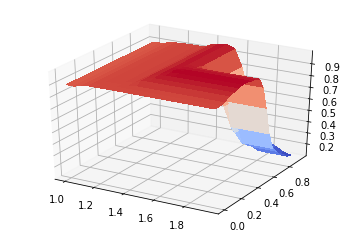

In [8]:
import pandas as pd
labels = pd.read_excel(sample_path+'/labels.xlsx', sheetname='labels')
labels['scene'] = pd.to_numeric(labels['scene'].replace('none','0'))
labels = labels.set_index('frame')
labels = (labels.to_dict())['scene']


bestAccuracy = 0
bestSumParam = 0
bestSIFT = 0

X = np.arange(1.0, 2.0, 0.05)
Y = np.arange(0.0, 1.0, 0.05)

#X = np.array([1.35]) #pabk 1.35
#Y = np.array([0.45]) #pabk 0.60

print(X)
print(Y)

Z = []
for minimumSum in X:
    line = []
    Z.append(line)
    for minimumSIFT in Y:
        for frames in recordingsResults:
            # DETERMINE SCENES (based on pre-computed frame-scene similarities)
            for frame in frames:
                if not frame.similarities: continue #in case the frame is in a group
                bestSum = 0
                bestScene = emptyFrame
                for similarity in frame.similarities:
                    simSIFT = similarity['simSIFT']
                    simSSIM = similarity['simSSIM']
                    scene = similarity['scene']
                    if(bestSum < simSIFT + simSSIM and (minimumSum < simSIFT + simSSIM or minimumSIFT < simSIFT)):
                        bestSum = simSIFT + simSSIM
                        bestScene = scene
                frame.assignedScene = bestScene
                for groupMember in frame.group:
                    groupMember.assignedScene = bestScene

            # FILTER ORPHANS 
            for frameNumber, currentFrame in enumerate(frames):
                if frameNumber == 0 : continue
                if frameNumber == len(frames)-1: continue
                previousScene = frames[frameNumber-1].assignedScene
                currentScene  = frames[frameNumber  ].assignedScene # (currentFrame)
                nextScene     = frames[frameNumber+1].assignedScene
                # Rule 1:
                if (currentScene is not previousScene) and (previousScene is nextScene):
                    currentFrame.assignedScene = previousScene
                    #print('Rule 1 applied on frame '+str(frameNumber))
                    continue
                # Rule 2:
                if (currentScene is not previousScene) and (currentScene is not nextScene) and (currentScene is not emptyFrame):
                    currentFrame.assignedScene = emptyFrame
                    #print('Rule 2 applied on frame '+str(frameNumber))
                    continue
            
        # COMPUTE ACCURACY
        totalCount = 0
        totalCorrect = 0
        for frames in recordingsResults:
            for frame in frames:
                totalCount += 1
                #print(type(frame.assignedScene.thisSceneNumber).__name__ + ' ' + type(labels[frame.fileName]).__name__)
                if(frame.assignedScene == None): continue
                if(frame.assignedScene.thisSceneNumber == labels[frame.fileName]):
                    totalCorrect += 1

        totalAccuracy = totalCorrect / totalCount
        line.append(totalAccuracy)

        #print('min SUM: ' + str(minimumSum) + ' min SIFT: ' + str(minimumSIFT) + ' accuracy: ' + str(totalAccuracy))

        if(totalAccuracy > bestAccuracy):
            bestAccuracy = totalAccuracy
            bestSumParam = minimumSum
            bestSIFT = minimumSIFT
            #print(bestSum)

print()
print('best SUM: ' + str(bestSumParam) + ' best SIFT: ' + str(bestSIFT) + ' best accuracy: ' + str(bestAccuracy))


X, Y = np.meshgrid(X, Y)
Z = np.array(Z)

print(X.shape)
print(Y.shape)
print(Z.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.show()



In [9]:
for frames in recordingsResults:
    for frame in frames:
        a = frame.fileName
        b = str(frame.assignedScene.thisSceneNumber)
        c = str(labels[frame.fileName])
        message = ""
        if (b != c):
            if (b == '0'): message = "insufficient similarity to any scene"
            else: 
                if (c == '0'): message = "no scene situation ended up classified as scene"
                else: message = "frame assigned to wrong scene (in scene situation)"
        print(a +' '+ b + ' ' + c + '   ' + message)

pabk_01_00008.png 1 1   
pabk_01_00009.png 1 1   
pabk_01_00010.png 1 1   
pabk_01_00011.png 1 1   
pabk_01_00012.png 1 1   
pabk_01_00013.png 0 1   insufficient similarity to any scene
pabk_01_00014.png 0 1   insufficient similarity to any scene
pabk_01_00015.png 0 1   insufficient similarity to any scene
pabk_01_00016.png 0 1   insufficient similarity to any scene
pabk_01_00017.png 0 1   insufficient similarity to any scene
pabk_01_00018.png 0 1   insufficient similarity to any scene
pabk_01_00019.png 0 1   insufficient similarity to any scene
pabk_01_00020.png 0 1   insufficient similarity to any scene
pabk_01_00021.png 0 1   insufficient similarity to any scene
pabk_01_00022.png 0 1   insufficient similarity to any scene
pabk_01_00023.png 0 1   insufficient similarity to any scene
pabk_01_00024.png 0 1   insufficient similarity to any scene
pabk_01_00025.png 0 1   insufficient similarity to any scene
pabk_01_00026.png 0 1   insufficient similarity to any scene
pabk_01_00027.png 0 1

pabk_01_00260.png 0 1   insufficient similarity to any scene
pabk_01_00261.png 0 1   insufficient similarity to any scene
pabk_01_00262.png 0 1   insufficient similarity to any scene
pabk_01_00263.png 0 1   insufficient similarity to any scene
pabk_01_00264.png 0 1   insufficient similarity to any scene
pabk_01_00265.png 0 1   insufficient similarity to any scene
pabk_01_00266.png 0 1   insufficient similarity to any scene
pabk_01_00267.png 0 1   insufficient similarity to any scene
pabk_01_00268.png 0 1   insufficient similarity to any scene
pabk_01_00269.png 0 1   insufficient similarity to any scene
pabk_01_00270.png 0 1   insufficient similarity to any scene
pabk_01_00271.png 0 1   insufficient similarity to any scene
pabk_01_00272.png 0 1   insufficient similarity to any scene
pabk_01_00273.png 0 1   insufficient similarity to any scene
pabk_01_00274.png 0 1   insufficient similarity to any scene
pabk_01_00275.png 0 1   insufficient similarity to any scene
pabk_01_00276.png 0 1   

pabk_01_01300.png 0 5   insufficient similarity to any scene
pabk_01_01301.png 0 5   insufficient similarity to any scene
pabk_01_01302.png 0 5   insufficient similarity to any scene
pabk_01_01303.png 0 5   insufficient similarity to any scene
pabk_01_01304.png 0 5   insufficient similarity to any scene
pabk_01_01305.png 0 5   insufficient similarity to any scene
pabk_01_01306.png 0 5   insufficient similarity to any scene
pabk_01_01307.png 0 5   insufficient similarity to any scene
pabk_01_01308.png 0 5   insufficient similarity to any scene
pabk_01_01309.png 0 5   insufficient similarity to any scene
pabk_01_01310.png 0 5   insufficient similarity to any scene
pabk_01_01311.png 0 5   insufficient similarity to any scene
pabk_01_01312.png 0 5   insufficient similarity to any scene
pabk_01_01313.png 0 5   insufficient similarity to any scene
pabk_01_01314.png 0 5   insufficient similarity to any scene
pabk_01_01315.png 0 5   insufficient similarity to any scene
pabk_01_01316.png 0 5   

pabk_01_02250.png 0 7   insufficient similarity to any scene
pabk_01_02251.png 0 7   insufficient similarity to any scene
pabk_01_02252.png 0 7   insufficient similarity to any scene
pabk_01_02253.png 0 7   insufficient similarity to any scene
pabk_01_02254.png 0 7   insufficient similarity to any scene
pabk_01_02255.png 0 7   insufficient similarity to any scene
pabk_01_02256.png 0 7   insufficient similarity to any scene
pabk_01_02257.png 0 7   insufficient similarity to any scene
pabk_01_02258.png 0 7   insufficient similarity to any scene
pabk_01_02259.png 0 7   insufficient similarity to any scene
pabk_01_02260.png 0 7   insufficient similarity to any scene
pabk_01_02261.png 0 7   insufficient similarity to any scene
pabk_01_02262.png 0 7   insufficient similarity to any scene
pabk_01_02263.png 0 7   insufficient similarity to any scene
pabk_01_02264.png 0 7   insufficient similarity to any scene
pabk_01_02265.png 0 7   insufficient similarity to any scene
pabk_01_02266.png 0 7   

pabk_01_03248.png 0 11   insufficient similarity to any scene
pabk_01_03249.png 0 11   insufficient similarity to any scene
pabk_01_03250.png 0 11   insufficient similarity to any scene
pabk_01_03251.png 0 11   insufficient similarity to any scene
pabk_01_03252.png 0 11   insufficient similarity to any scene
pabk_01_03253.png 0 11   insufficient similarity to any scene
pabk_01_03254.png 0 11   insufficient similarity to any scene
pabk_01_03255.png 0 11   insufficient similarity to any scene
pabk_01_03256.png 0 11   insufficient similarity to any scene
pabk_01_03257.png 0 11   insufficient similarity to any scene
pabk_01_03258.png 0 11   insufficient similarity to any scene
pabk_01_03259.png 0 11   insufficient similarity to any scene
pabk_01_03260.png 0 11   insufficient similarity to any scene
pabk_01_03261.png 0 11   insufficient similarity to any scene
pabk_01_03262.png 0 11   insufficient similarity to any scene
pabk_01_03263.png 0 11   insufficient similarity to any scene
pabk_01_

pabk_01_04274.png 0 12   insufficient similarity to any scene
pabk_01_04275.png 0 12   insufficient similarity to any scene
pabk_01_04276.png 0 12   insufficient similarity to any scene
pabk_01_04277.png 0 12   insufficient similarity to any scene
pabk_01_04278.png 0 12   insufficient similarity to any scene
pabk_01_04279.png 0 12   insufficient similarity to any scene
pabk_01_04280.png 0 12   insufficient similarity to any scene
pabk_01_04281.png 0 12   insufficient similarity to any scene
pabk_01_04282.png 0 12   insufficient similarity to any scene
pabk_01_04283.png 0 12   insufficient similarity to any scene
pabk_01_04284.png 0 12   insufficient similarity to any scene
pabk_01_04285.png 0 12   insufficient similarity to any scene
pabk_01_04286.png 0 12   insufficient similarity to any scene
pabk_01_04287.png 0 12   insufficient similarity to any scene
pabk_01_04288.png 0 12   insufficient similarity to any scene
pabk_01_04289.png 0 11   insufficient similarity to any scene
pabk_01_

pabk_01_05258.png 0 1   insufficient similarity to any scene
pabk_01_05259.png 0 1   insufficient similarity to any scene
pabk_01_05260.png 0 1   insufficient similarity to any scene
pabk_01_05261.png 0 1   insufficient similarity to any scene
pabk_01_05262.png 0 1   insufficient similarity to any scene
pabk_01_05263.png 0 1   insufficient similarity to any scene
pabk_01_05264.png 0 1   insufficient similarity to any scene
pabk_01_05265.png 0 1   insufficient similarity to any scene
pabk_01_05266.png 0 1   insufficient similarity to any scene
pabk_01_05267.png 0 1   insufficient similarity to any scene
pabk_01_05268.png 0 1   insufficient similarity to any scene
pabk_01_05269.png 0 1   insufficient similarity to any scene
pabk_01_05270.png 0 1   insufficient similarity to any scene
pabk_01_05271.png 0 1   insufficient similarity to any scene
pabk_01_05272.png 0 1   insufficient similarity to any scene
pabk_01_05273.png 0 1   insufficient similarity to any scene
pabk_01_05274.png 0 1   

pabk_02_00105.png 0 1   insufficient similarity to any scene
pabk_02_00106.png 0 1   insufficient similarity to any scene
pabk_02_00107.png 0 1   insufficient similarity to any scene
pabk_02_00108.png 0 1   insufficient similarity to any scene
pabk_02_00109.png 0 1   insufficient similarity to any scene
pabk_02_00110.png 0 1   insufficient similarity to any scene
pabk_02_00111.png 0 1   insufficient similarity to any scene
pabk_02_00112.png 0 1   insufficient similarity to any scene
pabk_02_00113.png 0 1   insufficient similarity to any scene
pabk_02_00114.png 0 1   insufficient similarity to any scene
pabk_02_00115.png 0 1   insufficient similarity to any scene
pabk_02_00116.png 0 1   insufficient similarity to any scene
pabk_02_00117.png 0 1   insufficient similarity to any scene
pabk_02_00118.png 0 1   insufficient similarity to any scene
pabk_02_00119.png 0 1   insufficient similarity to any scene
pabk_02_00120.png 0 1   insufficient similarity to any scene
pabk_02_00121.png 0 1   

pabk_02_01084.png 0 6   insufficient similarity to any scene
pabk_02_01085.png 0 6   insufficient similarity to any scene
pabk_02_01086.png 0 6   insufficient similarity to any scene
pabk_02_01087.png 0 6   insufficient similarity to any scene
pabk_02_01088.png 0 6   insufficient similarity to any scene
pabk_02_01089.png 0 6   insufficient similarity to any scene
pabk_02_01090.png 0 6   insufficient similarity to any scene
pabk_02_01091.png 0 6   insufficient similarity to any scene
pabk_02_01092.png 0 6   insufficient similarity to any scene
pabk_02_01093.png 0 6   insufficient similarity to any scene
pabk_02_01094.png 0 6   insufficient similarity to any scene
pabk_02_01095.png 0 6   insufficient similarity to any scene
pabk_02_01096.png 0 6   insufficient similarity to any scene
pabk_02_01097.png 0 6   insufficient similarity to any scene
pabk_02_01098.png 0 6   insufficient similarity to any scene
pabk_02_01099.png 0 6   insufficient similarity to any scene
pabk_02_01100.png 0 6   

pabk_02_02111.png 0 10   insufficient similarity to any scene
pabk_02_02112.png 0 10   insufficient similarity to any scene
pabk_02_02113.png 0 10   insufficient similarity to any scene
pabk_02_02114.png 0 10   insufficient similarity to any scene
pabk_02_02115.png 0 10   insufficient similarity to any scene
pabk_02_02116.png 0 10   insufficient similarity to any scene
pabk_02_02117.png 0 10   insufficient similarity to any scene
pabk_02_02118.png 0 10   insufficient similarity to any scene
pabk_02_02119.png 0 10   insufficient similarity to any scene
pabk_02_02120.png 0 10   insufficient similarity to any scene
pabk_02_02121.png 0 10   insufficient similarity to any scene
pabk_02_02122.png 0 10   insufficient similarity to any scene
pabk_02_02123.png 0 10   insufficient similarity to any scene
pabk_02_02124.png 0 10   insufficient similarity to any scene
pabk_02_02125.png 0 10   insufficient similarity to any scene
pabk_02_02126.png 0 10   insufficient similarity to any scene
pabk_02_

pabk_02_03102.png 0 12   insufficient similarity to any scene
pabk_02_03103.png 0 12   insufficient similarity to any scene
pabk_02_03104.png 0 12   insufficient similarity to any scene
pabk_02_03105.png 0 12   insufficient similarity to any scene
pabk_02_03106.png 0 12   insufficient similarity to any scene
pabk_02_03107.png 0 12   insufficient similarity to any scene
pabk_02_03108.png 0 12   insufficient similarity to any scene
pabk_02_03109.png 0 12   insufficient similarity to any scene
pabk_02_03110.png 0 12   insufficient similarity to any scene
pabk_02_03111.png 0 12   insufficient similarity to any scene
pabk_02_03112.png 0 12   insufficient similarity to any scene
pabk_02_03113.png 0 12   insufficient similarity to any scene
pabk_02_03114.png 0 12   insufficient similarity to any scene
pabk_02_03115.png 0 12   insufficient similarity to any scene
pabk_02_03116.png 0 12   insufficient similarity to any scene
pabk_02_03117.png 0 12   insufficient similarity to any scene
pabk_02_

pabk_02_04088.png 0 5   insufficient similarity to any scene
pabk_02_04089.png 0 5   insufficient similarity to any scene
pabk_02_04090.png 0 5   insufficient similarity to any scene
pabk_02_04091.png 0 5   insufficient similarity to any scene
pabk_02_04092.png 0 5   insufficient similarity to any scene
pabk_02_04093.png 0 5   insufficient similarity to any scene
pabk_02_04094.png 0 5   insufficient similarity to any scene
pabk_02_04095.png 0 5   insufficient similarity to any scene
pabk_02_04096.png 0 5   insufficient similarity to any scene
pabk_02_04097.png 0 5   insufficient similarity to any scene
pabk_02_04098.png 0 5   insufficient similarity to any scene
pabk_02_04099.png 0 5   insufficient similarity to any scene
pabk_02_04100.png 0 5   insufficient similarity to any scene
pabk_02_04101.png 0 5   insufficient similarity to any scene
pabk_02_04102.png 0 5   insufficient similarity to any scene
pabk_02_04103.png 0 5   insufficient similarity to any scene
pabk_02_04104.png 0 5   

pabk_02_05106.png 0 1   insufficient similarity to any scene
pabk_02_05107.png 0 1   insufficient similarity to any scene
pabk_02_05108.png 0 1   insufficient similarity to any scene
pabk_02_05109.png 0 1   insufficient similarity to any scene
pabk_02_05110.png 0 1   insufficient similarity to any scene
pabk_02_05111.png 0 1   insufficient similarity to any scene
pabk_02_05112.png 0 1   insufficient similarity to any scene
pabk_02_05113.png 0 1   insufficient similarity to any scene
pabk_02_05114.png 0 1   insufficient similarity to any scene
pabk_02_05115.png 0 1   insufficient similarity to any scene
pabk_02_05116.png 0 1   insufficient similarity to any scene
pabk_02_05117.png 0 1   insufficient similarity to any scene
pabk_02_05118.png 0 1   insufficient similarity to any scene
pabk_02_05119.png 0 1   insufficient similarity to any scene
pabk_02_05120.png 0 1   insufficient similarity to any scene
pabk_02_05121.png 0 1   insufficient similarity to any scene
pabk_02_05122.png 0 1   

pabk_03_00477.png 0 4   insufficient similarity to any scene
pabk_03_00478.png 0 4   insufficient similarity to any scene
pabk_03_00479.png 0 4   insufficient similarity to any scene
pabk_03_00480.png 0 4   insufficient similarity to any scene
pabk_03_00481.png 0 4   insufficient similarity to any scene
pabk_03_00482.png 0 4   insufficient similarity to any scene
pabk_03_00483.png 0 4   insufficient similarity to any scene
pabk_03_00484.png 0 4   insufficient similarity to any scene
pabk_03_00485.png 0 4   insufficient similarity to any scene
pabk_03_00486.png 0 4   insufficient similarity to any scene
pabk_03_00487.png 0 4   insufficient similarity to any scene
pabk_03_00488.png 0 4   insufficient similarity to any scene
pabk_03_00489.png 0 4   insufficient similarity to any scene
pabk_03_00490.png 0 4   insufficient similarity to any scene
pabk_03_00491.png 0 4   insufficient similarity to any scene
pabk_03_00492.png 0 4   insufficient similarity to any scene
pabk_03_00493.png 0 4   

pabk_03_01499.png 0 0   
pabk_03_01500.png 0 0   
pabk_03_01501.png 0 0   
pabk_03_01502.png 0 0   
pabk_03_01503.png 0 0   
pabk_03_01504.png 0 0   
pabk_03_01505.png 0 0   
pabk_03_01506.png 0 0   
pabk_03_01507.png 0 0   
pabk_03_01508.png 0 0   
pabk_03_01509.png 0 0   
pabk_03_01510.png 0 0   
pabk_03_01511.png 0 0   
pabk_03_01512.png 0 0   
pabk_03_01513.png 0 0   
pabk_03_01514.png 0 0   
pabk_03_01515.png 0 0   
pabk_03_01516.png 0 0   
pabk_03_01517.png 0 0   
pabk_03_01518.png 0 0   
pabk_03_01519.png 0 0   
pabk_03_01520.png 0 0   
pabk_03_01521.png 0 0   
pabk_03_01522.png 0 0   
pabk_03_01523.png 0 0   
pabk_03_01524.png 0 0   
pabk_03_01525.png 0 0   
pabk_03_01526.png 0 0   
pabk_03_01527.png 0 0   
pabk_03_01528.png 0 0   
pabk_03_01529.png 0 0   
pabk_03_01530.png 0 0   
pabk_03_01531.png 0 0   
pabk_03_01532.png 0 0   
pabk_03_01533.png 0 0   
pabk_03_01534.png 0 0   
pabk_03_01535.png 0 0   
pabk_03_01536.png 0 0   
pabk_03_01537.png 0 0   
pabk_03_01538.png 0 0   


pabk_03_02457.png 0 12   insufficient similarity to any scene
pabk_03_02458.png 0 12   insufficient similarity to any scene
pabk_03_02459.png 0 12   insufficient similarity to any scene
pabk_03_02460.png 0 12   insufficient similarity to any scene
pabk_03_02461.png 0 12   insufficient similarity to any scene
pabk_03_02462.png 0 12   insufficient similarity to any scene
pabk_03_02463.png 0 12   insufficient similarity to any scene
pabk_03_02464.png 0 12   insufficient similarity to any scene
pabk_03_02465.png 0 12   insufficient similarity to any scene
pabk_03_02466.png 0 12   insufficient similarity to any scene
pabk_03_02467.png 0 12   insufficient similarity to any scene
pabk_03_02468.png 0 12   insufficient similarity to any scene
pabk_03_02469.png 0 12   insufficient similarity to any scene
pabk_03_02470.png 0 12   insufficient similarity to any scene
pabk_03_02471.png 0 12   insufficient similarity to any scene
pabk_03_02472.png 0 12   insufficient similarity to any scene
pabk_03_

pabk_03_03491.png 0 5   insufficient similarity to any scene
pabk_03_03492.png 0 5   insufficient similarity to any scene
pabk_03_03493.png 0 5   insufficient similarity to any scene
pabk_03_03494.png 0 5   insufficient similarity to any scene
pabk_03_03495.png 0 5   insufficient similarity to any scene
pabk_03_03496.png 0 5   insufficient similarity to any scene
pabk_03_03497.png 0 5   insufficient similarity to any scene
pabk_03_03498.png 0 5   insufficient similarity to any scene
pabk_03_03499.png 0 5   insufficient similarity to any scene
pabk_03_03500.png 0 5   insufficient similarity to any scene
pabk_03_03501.png 0 5   insufficient similarity to any scene
pabk_03_03502.png 0 5   insufficient similarity to any scene
pabk_03_03503.png 0 5   insufficient similarity to any scene
pabk_03_03504.png 0 5   insufficient similarity to any scene
pabk_03_03505.png 0 5   insufficient similarity to any scene
pabk_03_03506.png 0 5   insufficient similarity to any scene
pabk_03_03507.png 0 5   

pabk_03_04468.png 0 5   insufficient similarity to any scene
pabk_03_04469.png 0 5   insufficient similarity to any scene
pabk_03_04470.png 0 5   insufficient similarity to any scene
pabk_03_04471.png 0 5   insufficient similarity to any scene
pabk_03_04472.png 0 5   insufficient similarity to any scene
pabk_03_04473.png 0 5   insufficient similarity to any scene
pabk_03_04474.png 0 5   insufficient similarity to any scene
pabk_03_04475.png 0 5   insufficient similarity to any scene
pabk_03_04476.png 0 5   insufficient similarity to any scene
pabk_03_04477.png 0 5   insufficient similarity to any scene
pabk_03_04478.png 0 5   insufficient similarity to any scene
pabk_03_04479.png 0 5   insufficient similarity to any scene
pabk_03_04480.png 0 5   insufficient similarity to any scene
pabk_03_04481.png 0 5   insufficient similarity to any scene
pabk_03_04482.png 0 5   insufficient similarity to any scene
pabk_03_04483.png 0 5   insufficient similarity to any scene
pabk_03_04484.png 0 5   

pabk_04_00478.png 0 5   insufficient similarity to any scene
pabk_04_00479.png 0 5   insufficient similarity to any scene
pabk_04_00480.png 0 5   insufficient similarity to any scene
pabk_04_00481.png 0 5   insufficient similarity to any scene
pabk_04_00482.png 0 5   insufficient similarity to any scene
pabk_04_00483.png 0 5   insufficient similarity to any scene
pabk_04_00484.png 0 5   insufficient similarity to any scene
pabk_04_00485.png 0 5   insufficient similarity to any scene
pabk_04_00486.png 0 5   insufficient similarity to any scene
pabk_04_00487.png 0 5   insufficient similarity to any scene
pabk_04_00488.png 0 5   insufficient similarity to any scene
pabk_04_00489.png 0 5   insufficient similarity to any scene
pabk_04_00490.png 0 5   insufficient similarity to any scene
pabk_04_00491.png 0 5   insufficient similarity to any scene
pabk_04_00492.png 0 5   insufficient similarity to any scene
pabk_04_00493.png 0 5   insufficient similarity to any scene
pabk_04_00494.png 0 5   

pabk_04_01493.png 0 9   insufficient similarity to any scene
pabk_04_01494.png 0 9   insufficient similarity to any scene
pabk_04_01495.png 0 9   insufficient similarity to any scene
pabk_04_01496.png 0 9   insufficient similarity to any scene
pabk_04_01497.png 0 9   insufficient similarity to any scene
pabk_04_01498.png 0 9   insufficient similarity to any scene
pabk_04_01499.png 0 9   insufficient similarity to any scene
pabk_04_01500.png 0 9   insufficient similarity to any scene
pabk_04_01501.png 0 9   insufficient similarity to any scene
pabk_04_01502.png 0 9   insufficient similarity to any scene
pabk_04_01503.png 0 9   insufficient similarity to any scene
pabk_04_01504.png 0 9   insufficient similarity to any scene
pabk_04_01505.png 0 9   insufficient similarity to any scene
pabk_04_01506.png 0 9   insufficient similarity to any scene
pabk_04_01507.png 0 9   insufficient similarity to any scene
pabk_04_01508.png 0 9   insufficient similarity to any scene
pabk_04_01509.png 0 9   

pabk_04_02506.png 0 12   insufficient similarity to any scene
pabk_04_02507.png 0 12   insufficient similarity to any scene
pabk_04_02508.png 0 12   insufficient similarity to any scene
pabk_04_02509.png 0 12   insufficient similarity to any scene
pabk_04_02510.png 0 12   insufficient similarity to any scene
pabk_04_02511.png 0 12   insufficient similarity to any scene
pabk_04_02512.png 0 12   insufficient similarity to any scene
pabk_04_02513.png 0 12   insufficient similarity to any scene
pabk_04_02514.png 0 12   insufficient similarity to any scene
pabk_04_02515.png 0 12   insufficient similarity to any scene
pabk_04_02516.png 0 12   insufficient similarity to any scene
pabk_04_02517.png 0 12   insufficient similarity to any scene
pabk_04_02518.png 0 12   insufficient similarity to any scene
pabk_04_02519.png 0 12   insufficient similarity to any scene
pabk_04_02520.png 0 12   insufficient similarity to any scene
pabk_04_02521.png 0 12   insufficient similarity to any scene
pabk_04_

pabk_04_03529.png 0 5   insufficient similarity to any scene
pabk_04_03530.png 0 5   insufficient similarity to any scene
pabk_04_03531.png 0 5   insufficient similarity to any scene
pabk_04_03532.png 0 5   insufficient similarity to any scene
pabk_04_03533.png 0 5   insufficient similarity to any scene
pabk_04_03534.png 0 5   insufficient similarity to any scene
pabk_04_03535.png 0 5   insufficient similarity to any scene
pabk_04_03536.png 0 5   insufficient similarity to any scene
pabk_04_03537.png 0 5   insufficient similarity to any scene
pabk_04_03538.png 0 5   insufficient similarity to any scene
pabk_04_03539.png 0 5   insufficient similarity to any scene
pabk_04_03540.png 0 5   insufficient similarity to any scene
pabk_04_03541.png 0 5   insufficient similarity to any scene
pabk_04_03542.png 0 5   insufficient similarity to any scene
pabk_04_03543.png 0 5   insufficient similarity to any scene
pabk_04_03544.png 0 5   insufficient similarity to any scene
pabk_04_03545.png 0 5   

pabk_04_04480.png 0 0   
pabk_04_04481.png 0 0   
pabk_04_04482.png 0 0   
pabk_04_04483.png 0 0   
pabk_04_04484.png 0 0   
pabk_04_04485.png 0 0   
pabk_04_04486.png 0 0   
pabk_04_04487.png 0 0   
pabk_04_04488.png 0 0   
pabk_04_04489.png 0 0   
pabk_04_04490.png 0 0   
pabk_04_04491.png 0 0   
pabk_04_04492.png 0 0   
pabk_04_04493.png 0 0   
pabk_04_04494.png 0 0   
pabk_04_04495.png 0 0   
pabk_04_04496.png 0 0   
pabk_04_04497.png 0 0   
pabk_04_04498.png 0 0   
pabk_04_04499.png 0 0   
pabk_04_04500.png 0 0   
pabk_04_04501.png 0 0   
pabk_04_04502.png 0 0   
pabk_04_04503.png 0 0   
pabk_04_04504.png 0 0   
pabk_04_04505.png 0 0   
pabk_04_04506.png 0 0   
pabk_04_04507.png 0 0   
pabk_04_04508.png 0 0   
pabk_04_04509.png 0 0   
pabk_04_04510.png 0 0   
pabk_04_04511.png 0 0   
pabk_04_04512.png 0 0   
pabk_04_04513.png 0 0   
pabk_04_04514.png 0 0   
pabk_04_04515.png 0 0   
pabk_04_04516.png 0 0   
pabk_04_04517.png 0 0   
pabk_04_04518.png 0 0   
pabk_04_04519.png 0 0   


pabk_05_00882.png 0 5   insufficient similarity to any scene
pabk_05_00883.png 0 5   insufficient similarity to any scene
pabk_05_00884.png 0 5   insufficient similarity to any scene
pabk_05_00885.png 0 5   insufficient similarity to any scene
pabk_05_00886.png 0 5   insufficient similarity to any scene
pabk_05_00887.png 0 5   insufficient similarity to any scene
pabk_05_00888.png 0 5   insufficient similarity to any scene
pabk_05_00889.png 0 5   insufficient similarity to any scene
pabk_05_00890.png 0 5   insufficient similarity to any scene
pabk_05_00891.png 0 5   insufficient similarity to any scene
pabk_05_00892.png 0 5   insufficient similarity to any scene
pabk_05_00893.png 0 5   insufficient similarity to any scene
pabk_05_00894.png 0 5   insufficient similarity to any scene
pabk_05_00895.png 0 5   insufficient similarity to any scene
pabk_05_00896.png 0 5   insufficient similarity to any scene
pabk_05_00897.png 0 5   insufficient similarity to any scene
pabk_05_00898.png 0 5   

pabk_05_01852.png 0 7   insufficient similarity to any scene
pabk_05_01853.png 0 7   insufficient similarity to any scene
pabk_05_01854.png 0 7   insufficient similarity to any scene
pabk_05_01855.png 0 7   insufficient similarity to any scene
pabk_05_01856.png 0 7   insufficient similarity to any scene
pabk_05_01857.png 0 7   insufficient similarity to any scene
pabk_05_01858.png 0 7   insufficient similarity to any scene
pabk_05_01859.png 0 7   insufficient similarity to any scene
pabk_05_01860.png 0 7   insufficient similarity to any scene
pabk_05_01861.png 0 7   insufficient similarity to any scene
pabk_05_01862.png 0 7   insufficient similarity to any scene
pabk_05_01863.png 0 7   insufficient similarity to any scene
pabk_05_01864.png 0 7   insufficient similarity to any scene
pabk_05_01865.png 0 7   insufficient similarity to any scene
pabk_05_01866.png 0 7   insufficient similarity to any scene
pabk_05_01867.png 0 7   insufficient similarity to any scene
pabk_05_01868.png 0 7   

pabk_05_02900.png 0 11   insufficient similarity to any scene
pabk_05_02901.png 0 11   insufficient similarity to any scene
pabk_05_02902.png 0 11   insufficient similarity to any scene
pabk_05_02903.png 0 11   insufficient similarity to any scene
pabk_05_02904.png 0 11   insufficient similarity to any scene
pabk_05_02905.png 0 11   insufficient similarity to any scene
pabk_05_02906.png 0 11   insufficient similarity to any scene
pabk_05_02907.png 0 11   insufficient similarity to any scene
pabk_05_02908.png 0 11   insufficient similarity to any scene
pabk_05_02909.png 0 11   insufficient similarity to any scene
pabk_05_02910.png 0 11   insufficient similarity to any scene
pabk_05_02911.png 0 11   insufficient similarity to any scene
pabk_05_02912.png 0 11   insufficient similarity to any scene
pabk_05_02913.png 0 11   insufficient similarity to any scene
pabk_05_02914.png 0 11   insufficient similarity to any scene
pabk_05_02915.png 0 11   insufficient similarity to any scene
pabk_05_

pabk_05_03843.png 0 5   insufficient similarity to any scene
pabk_05_03844.png 0 5   insufficient similarity to any scene
pabk_05_03845.png 0 5   insufficient similarity to any scene
pabk_05_03846.png 0 5   insufficient similarity to any scene
pabk_05_03847.png 0 5   insufficient similarity to any scene
pabk_05_03848.png 0 5   insufficient similarity to any scene
pabk_05_03849.png 0 5   insufficient similarity to any scene
pabk_05_03850.png 0 5   insufficient similarity to any scene
pabk_05_03851.png 0 5   insufficient similarity to any scene
pabk_05_03852.png 0 5   insufficient similarity to any scene
pabk_05_03853.png 0 5   insufficient similarity to any scene
pabk_05_03854.png 0 5   insufficient similarity to any scene
pabk_05_03855.png 0 5   insufficient similarity to any scene
pabk_05_03856.png 0 5   insufficient similarity to any scene
pabk_05_03857.png 0 5   insufficient similarity to any scene
pabk_05_03858.png 0 5   insufficient similarity to any scene
pabk_05_03859.png 0 5   